In [1]:
# !pip install openpyxl            #to read .xlsx format files
import numpy as np
import pandas as pd
import time
import math
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
#_______________++============= In this cell all functions will be created===========++______________________
#------------------------------------------------------------------------------------------------------------


#=============================== Let's get data information =================================================

def dataset_info():
    '''this function reads the information about all datas
       and returns informations as a pandas table BKS'''
    
    #readin excel format file with pandas
    BKS =  pd.read_excel('BKS.xlsx', sheet_name='BKS')
    
    #rename the features
    BKS.rename(columns={'Ins':'file_name', 'n':'Nom_of_node', 'K':'K_min', 'Q':'veh_cap'}, inplace=True)
    
    # Add '.txt' to file_name values
    for i in range(30):
        BKS.loc[i,'file_name'] = BKS.loc[i,'file_name']+str('.txt')
    return BKS
#================================ Function was created =========================================================




#================================ reading all text files ========================================================

def get_files(info):
    ''' This function reads all text files and pass them to a dictionary'''
    
    # Reading each file.txt as a table an save all them in a dictionary
    File_Name_dic = {}
    rows= info.index.tolist()
    for row in rows:
        File_Name_dic['data'+str(row)] = pd.read_table(info.loc[row, 'file_name'])
    return rows, File_Name_dic

#================================ Function was created =========================================================





# ======================== Extracting Tables from each File ====================================================
def get_table(BKS, File_Name_dic):
    ''' Extracts tables from text files and saves them as dictionaries'''
    
    Locations={}
    Demands = {}
    
    # defining some parameters for slicing 
    L_N = 6+BKS['Nom_of_node']
    D_N_L = L_N+2
    D_N_U = D_N_L + BKS['Nom_of_node']
    
    # reading cotumers' location and costumers' demand from each file
    for row in rows:
        Locations['loc'+str(row)] = File_Name_dic['data'+str(row)].loc[6:L_N[row]]
        col2 = str(Locations['loc'+str(row)].columns[1])
        Locations['loc'+str(row)].rename(columns={'NAME : ':'ind',col2:'x','Unnamed: 2':'y'}, inplace=True)
        Locations['loc'+str(row)].set_index('ind', inplace=True)
    
        Demands['dem'+str(row)] = File_Name_dic['data'+str(row)].loc[D_N_L[row]:D_N_U[row]]
        Demands['dem'+str(row)].rename(columns={'NAME : ':'ind',col2:'d'}, inplace=True)
        Demands['dem'+str(row)].set_index('ind', inplace=True)
        Demands['dem'+str(row)].drop('Unnamed: 2',axis=1, inplace=True)
    return Locations, Demands
#================================ Function was created =========================================================





# ========================== Extracting cartesian coordinates ==================================================

def coordinates(df, BKS):
    '''return coordinates all points'''
    depo = df.iloc[0,:]
    x_d, y_d = depo[0], depo[1]
    x_c, y_c = df['x'][1:], df['y'][1:]
    return x_d, y_d, x_c, y_c
#================================ Function was created =========================================================





# ========================== Initial solution function (random selection) =========================================

def initial_solution(param, dist):
    ''' gets parameters and distance and create a random feasible solution '''
    
    n = param['num_of_customer']
    d = param['demand']
    Q = param['capacity']
    N = param['customer_list']

#=============================== First method (Random initial solution)============================================
    Initial_Rout={}
    H = [a for a in range(n+1)]
    coord_h = [(a,b) for a in H for b in H if a!=b]
    Y = {(a,b):dist[(a,b)] for a,b in coord_h}
    all_checked = [False for a in range(1, n+1)]
    j = 0
    Initial_Rout[j] = [0]
    node_visited_init = [0]
    while sum(all_checked)!= n:
        a = Initial_Rout[j][-1]
        my_list = {}
        for b in H:
            if b not in node_visited_init:
                if b!=a:
                    my_list[b]=Y[(a,b)]
        my_list_as = {k: v for k, v in sorted(my_list.items(), key=lambda item: item[1])}
        my_list_key = list(my_list_as.keys())
        my_list_value = list(my_list_as.values())
        i = 0
        node_ass = False
        rout_deman = [d[a] for a in Initial_Rout[j]]
        u = np.sum(rout_deman)
        while node_ass == False:
            visit = my_list_key[i]
            if all_checked[visit-1]==False:
                if u+d[visit] <= Q:
                    Initial_Rout[j].append(visit)
                    all_checked[visit-1]=True
                    u = u+d[visit]
                    a = visit
                    node_visited_init.append(visit)
                    node_ass = True
                    break
            i+=1
            if i >=len(my_list_key):
                break
        node_not_visited = [a for a in H if a not in node_visited_init]
        node_not_vi_dem = [d[a] for a in node_not_visited]
        rout_deman = [d[a] for a in Initial_Rout[j]]
        slack = Q - np.sum(rout_deman)
        try:
            if slack < min(node_not_vi_dem):
                j+=1
                Initial_Rout[j] =[0]
        except: ValueError
    return Initial_Rout
#============================= Second method (heuristic initial solution)===========================================
#     Initial_Route = {}   
#     is_visited = [False for i in range(n)]
#     random.shuffle(N)
#     j=0
#     # for each customer checks the capacity feasibility of a route and assigns it
#     while sum(is_visited)!=n:
#         u = 0
#         Initial_Route[j] = [0]
#         for i in N:
#             if is_visited[i-1]==False:
#                 if u+d[i] <= Q:
#                     Initial_Route[j].append(i)
#                     is_visited[i-1]=True
#                     u = u+d[i]  
#         j+=1
#     return Initial_Route

#     Initial_Rout = {}
#     H = [a for a in range(n+1)]
#     coord_h = [(a,b) for a in H for b in H if a!=b]
#     Y = {(a,b):dist[(a,b)] for a,b in coord_h}
#     all_checked = [False for a in range(1, n+1)]

#     a = 0
#     j = 0
#     u = 0
#     Initial_Rout[j] = [0]
#     node_visited_init = [0]
#     while sum(all_checked)!= n:
    
#         min_dist = 10000
#         for b in H:
#             if b!=a:
#                 if b not in node_visited_init:
                
#                     if Y[(a,b)] < min_dist:
#                         min_dist = Y[(a,b)]
#                         visit = b
#         node_visited_init.append(visit)
#         if all_checked[visit-1]==False:
#             if u+d[visit] <= Q:
#                 Initial_Rout[j].append(visit)
#                 all_checked[visit-1]=True
#                 u = u+d[visit]
#                 a = visit
#             else:
#                 j+=1
#                 u = 0
#                 Initial_Rout[j] = [0]
#                 if u+d[visit] <= Q:
#                     Initial_Rout[j].append(visit)
#                     all_checked[visit-1]=True
#                     u = u+d[visit]
#                     a = visit

#     return Initial_Rout

#================================ Function was created =========================================================





# =================================== Active Arcs ==============================================================

def active_graph(Rout):
    ''' Gets route and and return active arcs in netwark'''
    
    Y = {(i,j):0 for i,j in coords}  #Binary variable is 1 if vehicle visits client j after visiting client i 
    for key in Rout.keys():
        for i in range(len(Rout[key])):
            if Rout[key][i] == Rout[key][-1]:
                j=0
            else: j = Rout[key][i+1]
            Y[Rout[key][i], j]=1
    return Y
#================================ Function was created =========================================================




# ============================== checking feasibility ==========================================================

def check_feasibility(X,param,Rout):
    ''' to check all constraint feasibility '''
    n = param['num_of_customer']
    N = param['customer_list']
    V = param['all_nodes']
    d = param['demand']
    Q = param['capacity']
    

    ## All customers have to be checked and only once
    Ca1=[]  #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>denoted first constraint 
    for j in N:
        c1=False
        cc1=0
        for i in V:
            if i!=j:
                cc1 += X[i,j]
        c1 = cc1==1
        Ca1.append(c1)
    C1 = sum(Ca1) == n #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>return true|false value

  
    #If a vehicle checks a customer, it has to dispatches
    #from there too, and summation of these dispatches have to be equal to one
    Ca2=[]  #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>denoted second constraint
    for i in N:
        c2=False
        cc2=0
        for j in V:
            if j!=i:
                cc2 += X[i,j]
        c2=cc2==1
        Ca2.append(c2)
    C2 = sum(Ca2) ==n #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>return true|false value f

   #all the client's demand for each rout have to less than or equal than vehicle capacity
    Rout_demand = []
    for rout in Rout.keys():
        q=0
        for i in Rout[rout]:
            q += d[i]
        Rout_demand.append(q)
    C3 = max(Rout_demand)<=Q
    Feasible = False  #>>>>>>>>>>>>>>>>>>>>>>this variable is true if and only if all constraints are satisified
    if C1==True and C2==True and C3== True:
        Feasible = True
    else: Feasible = False
        
    return Feasible, Rout_demand
#================================ Function was created =========================================================





# ============================== neighborhood solution ==========================================================

def neighborhood(param,path,dist,Iter):
    ''' gets current route and improves it '''
    # this funcion gets current path or route and passes clients to a list by allocation priority.
    # gets a client randomly and chooses it as the first client that will be visited.  
    # after that checks the list and assigns the nearest client  to the current route
    # actually, this function reorders clients by choosing a random client
    n = param['num_of_customer']
    N = param['customer_list']
    d = param['demand']
    Q = param['capacity']
    order_node = path.copy()

    merge=[0]
    for i in order_node.values():
            merge+=i
    my_list = np.asarray(merge)

    N =list(dict.fromkeys(my_list))
    N.remove(0)
    Initial_Route = {}
    j=0
    r = random.sample(N, 2)
    i1 = min(r)
    i2 = max(r)
    chance = np.random.uniform()
    if chance<0.33:
        N[i1-1],N[i2-1] = N[i2-1],N[i1-1]
    elif chance<0.66:
        N = N[0:i1]+N[i2:i1-1:-1]+N[i2+1:]
    else:
        N.remove(i2)
        N.insert(i1,i2)
    is_visited = [False for i in range(num_of_customer)]
    # for each customer checks the capacity feasibility of a route and assigns it
    while sum(is_visited)!=n:
        u = 0

        Initial_Route[j] = [0]
        for i in N:
            if is_visited[i-1]==False:
                if u+d[i] <= Q:
                    Initial_Route[j].append(i)
                    is_visited[i-1]=True
                    u = u+d[i]  
        j+=1
    return Initial_Route

#================================ Function was created =========================================================



# ============================== computes Rout's cost ==========================================================
def comput_cost(D, active):
    '''to compute objective or loss function'''
    Total_cost = 0
    for i,j in active:
        Total_cost +=D[i,j]
    return Total_cost
#================================ Function was created =========================================================


loss is: 22924 <=====> bestsofar is:  22924  temprature is: 50
loss is: 31380 <=====> bestsofar is:  22924  temprature is: 49.95
loss is: 25973 <=====> bestsofar is:  22924  temprature is: 49.90005
loss is: 23356 <=====> bestsofar is:  22924  temprature is: 49.85014995
loss is: 25295 <=====> bestsofar is:  22924  temprature is: 49.800299800050006
loss is: 24668 <=====> bestsofar is:  22924  temprature is: 49.75049950024996
loss is: 27987 <=====> bestsofar is:  22924  temprature is: 49.70074900074971
loss is: 23019 <=====> bestsofar is:  22924  temprature is: 49.65104825174896
loss is: 29821 <=====> bestsofar is:  22924  temprature is: 49.601397203497214
loss is: 24894 <=====> bestsofar is:  22924  temprature is: 49.55179580629372
loss is: 28583 <=====> bestsofar is:  22924  temprature is: 49.50224401048742
loss is: 23591 <=====> bestsofar is:  22924  temprature is: 49.45274176647693
loss is: 26628 <=====> bestsofar is:  22924  temprature is: 49.40328902471045
loss is: 29103 <=====> bes

loss is: 27681 <=====> bestsofar is:  23059  temprature is: 44.92387855414632
loss is: 31760 <=====> bestsofar is:  23059  temprature is: 44.878954675592176
loss is: 26944 <=====> bestsofar is:  23059  temprature is: 44.83407572091659
loss is: 23708 <=====> bestsofar is:  23059  temprature is: 44.78924164519567
loss is: 23636 <=====> bestsofar is:  23059  temprature is: 44.744452403550476
loss is: 27592 <=====> bestsofar is:  23059  temprature is: 44.69970795114693
loss is: 25458 <=====> bestsofar is:  23059  temprature is: 44.65500824319578
loss is: 23493 <=====> bestsofar is:  23059  temprature is: 44.61035323495258
loss is: 24573 <=====> bestsofar is:  23059  temprature is: 44.56574288171763
loss is: 27932 <=====> bestsofar is:  23059  temprature is: 44.52117713883592
loss is: 25715 <=====> bestsofar is:  23059  temprature is: 44.476655961697084
loss is: 25211 <=====> bestsofar is:  23059  temprature is: 44.43217930573539
loss is: 26354 <=====> bestsofar is:  23059  temprature is: 4

loss is: 23419 <=====> bestsofar is:  23368  temprature is: 40.36309728695376
loss is: 27217 <=====> bestsofar is:  23368  temprature is: 40.322734189666804
loss is: 26272 <=====> bestsofar is:  23368  temprature is: 40.28241145547714
loss is: 27288 <=====> bestsofar is:  23368  temprature is: 40.24212904402166
loss is: 28484 <=====> bestsofar is:  23368  temprature is: 40.201886914977635
loss is: 28673 <=====> bestsofar is:  23368  temprature is: 40.16168502806266
loss is: 25909 <=====> bestsofar is:  23368  temprature is: 40.121523343034596
loss is: 29657 <=====> bestsofar is:  23368  temprature is: 40.081401819691564
loss is: 25981 <=====> bestsofar is:  23368  temprature is: 40.04132041787187
loss is: 28041 <=====> bestsofar is:  23368  temprature is: 40.001279097454
loss is: 27860 <=====> bestsofar is:  23368  temprature is: 39.96127781835655
loss is: 26355 <=====> bestsofar is:  23368  temprature is: 39.92131654053819
loss is: 23392 <=====> bestsofar is:  23368  temprature is: 39

loss is: 27745 <=====> bestsofar is:  23356  temprature is: 36.3016392510171
loss is: 26981 <=====> bestsofar is:  23325  temprature is: 36.265337611766086
loss is: 25781 <=====> bestsofar is:  23325  temprature is: 36.22907227415432
loss is: 27026 <=====> bestsofar is:  23325  temprature is: 36.192843201880166
loss is: 33259 <=====> bestsofar is:  23325  temprature is: 36.156650358678284
loss is: 26337 <=====> bestsofar is:  23325  temprature is: 36.12049370831961
loss is: 28797 <=====> bestsofar is:  23325  temprature is: 36.08437321461129
loss is: 32355 <=====> bestsofar is:  23325  temprature is: 36.048288841396676
loss is: 25500 <=====> bestsofar is:  23325  temprature is: 36.01224055255528
loss is: 30221 <=====> bestsofar is:  23325  temprature is: 35.97622831200272
loss is: 25289 <=====> bestsofar is:  23325  temprature is: 35.940252083690716
loss is: 26133 <=====> bestsofar is:  23325  temprature is: 35.904311831607025
loss is: 26214 <=====> bestsofar is:  23325  temprature is:

loss is: 33254 <=====> bestsofar is:  23328  temprature is: 32.681539057157735
loss is: 29038 <=====> bestsofar is:  23328  temprature is: 32.64885751810058
loss is: 28920 <=====> bestsofar is:  23328  temprature is: 32.61620866058248
loss is: 23503 <=====> bestsofar is:  23328  temprature is: 32.583592451921895
loss is: 24087 <=====> bestsofar is:  23328  temprature is: 32.551008859469974
loss is: 23341 <=====> bestsofar is:  23341  temprature is: 32.5184578506105
loss is: 25038 <=====> bestsofar is:  23341  temprature is: 32.48593939275989
loss is: 23406 <=====> bestsofar is:  23341  temprature is: 32.45345345336713
loss is: 25174 <=====> bestsofar is:  23341  temprature is: 32.42099999991377
loss is: 27933 <=====> bestsofar is:  23341  temprature is: 32.388578999913854
loss is: 28852 <=====> bestsofar is:  23341  temprature is: 32.35619042091394
loss is: 23872 <=====> bestsofar is:  23341  temprature is: 32.32383423049303
loss is: 29907 <=====> bestsofar is:  23341  temprature is: 3

loss is: 31558 <=====> bestsofar is:  23317  temprature is: 29.422445299480525
loss is: 26851 <=====> bestsofar is:  23317  temprature is: 29.393022854181044
loss is: 26579 <=====> bestsofar is:  23306  temprature is: 29.363629831326865
loss is: 26347 <=====> bestsofar is:  23306  temprature is: 29.334266201495538
loss is: 26912 <=====> bestsofar is:  23306  temprature is: 29.304931935294043
loss is: 25841 <=====> bestsofar is:  23306  temprature is: 29.27562700335875
loss is: 25222 <=====> bestsofar is:  23306  temprature is: 29.246351376355392
loss is: 26549 <=====> bestsofar is:  23306  temprature is: 29.217105024979038
loss is: 28668 <=====> bestsofar is:  23306  temprature is: 29.187887919954058
loss is: 26643 <=====> bestsofar is:  23306  temprature is: 29.158700032034105
loss is: 25013 <=====> bestsofar is:  23306  temprature is: 29.12954133200207
loss is: 30858 <=====> bestsofar is:  23306  temprature is: 29.10041179067007
loss is: 24135 <=====> bestsofar is:  23306  temprature

loss is: 26464 <=====> bestsofar is:  23306  temprature is: 26.461869057054578
loss is: 25708 <=====> bestsofar is:  23306  temprature is: 26.435407187997523
loss is: 25312 <=====> bestsofar is:  23306  temprature is: 26.408971780809527
loss is: 30962 <=====> bestsofar is:  23306  temprature is: 26.382562809028716
loss is: 31440 <=====> bestsofar is:  23306  temprature is: 26.356180246219687
loss is: 27362 <=====> bestsofar is:  23306  temprature is: 26.329824065973465
loss is: 27352 <=====> bestsofar is:  23306  temprature is: 26.30349424190749
loss is: 29495 <=====> bestsofar is:  23306  temprature is: 26.277190747665582
loss is: 34138 <=====> bestsofar is:  23306  temprature is: 26.250913556917915
loss is: 30806 <=====> bestsofar is:  23306  temprature is: 26.224662643360997
loss is: 27937 <=====> bestsofar is:  23306  temprature is: 26.198437980717635
loss is: 28980 <=====> bestsofar is:  23306  temprature is: 26.172239542736918
loss is: 25659 <=====> bestsofar is:  23306  tempratu

loss is: 31342 <=====> bestsofar is:  23316  temprature is: 23.77539583669683
loss is: 26143 <=====> bestsofar is:  23316  temprature is: 23.751620440860133
loss is: 28617 <=====> bestsofar is:  23316  temprature is: 23.727868820419275
loss is: 25110 <=====> bestsofar is:  23316  temprature is: 23.704140951598855
loss is: 25924 <=====> bestsofar is:  23316  temprature is: 23.680436810647258
loss is: 29540 <=====> bestsofar is:  23316  temprature is: 23.65675637383661
loss is: 26617 <=====> bestsofar is:  23316  temprature is: 23.633099617462776
loss is: 25635 <=====> bestsofar is:  23316  temprature is: 23.609466517845313
loss is: 31961 <=====> bestsofar is:  23316  temprature is: 23.585857051327466
loss is: 30032 <=====> bestsofar is:  23316  temprature is: 23.56227119427614
loss is: 24000 <=====> bestsofar is:  23316  temprature is: 23.538708923081863
loss is: 33231 <=====> bestsofar is:  23316  temprature is: 23.515170214158783
loss is: 23316 <=====> bestsofar is:  23316  temprature

loss is: 23429 <=====> bestsofar is:  23308  temprature is: 21.404447393229542
loss is: 23612 <=====> bestsofar is:  23308  temprature is: 21.383042945836312
loss is: 28273 <=====> bestsofar is:  23308  temprature is: 21.361659902890477
loss is: 33014 <=====> bestsofar is:  23308  temprature is: 21.340298242987586
loss is: 25082 <=====> bestsofar is:  23308  temprature is: 21.3189579447446
loss is: 30124 <=====> bestsofar is:  23308  temprature is: 21.297638986799857
loss is: 30669 <=====> bestsofar is:  23308  temprature is: 21.27634134781306
loss is: 27474 <=====> bestsofar is:  23308  temprature is: 21.255065006465244
loss is: 23427 <=====> bestsofar is:  23308  temprature is: 21.23380994145878
loss is: 31040 <=====> bestsofar is:  23308  temprature is: 21.21257613151732
loss is: 31667 <=====> bestsofar is:  23308  temprature is: 21.191363555385802
loss is: 29297 <=====> bestsofar is:  23308  temprature is: 21.170172191830417
loss is: 25736 <=====> bestsofar is:  23308  temprature i

loss is: 28830 <=====> bestsofar is:  23308  temprature is: 19.250666570811955
loss is: 26295 <=====> bestsofar is:  23308  temprature is: 19.231415904241143
loss is: 25712 <=====> bestsofar is:  23308  temprature is: 19.212184488336902
loss is: 30682 <=====> bestsofar is:  23308  temprature is: 19.192972303848567
loss is: 23907 <=====> bestsofar is:  23308  temprature is: 19.17377933154472
loss is: 26292 <=====> bestsofar is:  23308  temprature is: 19.154605552213173
loss is: 26827 <=====> bestsofar is:  23308  temprature is: 19.13545094666096
loss is: 25477 <=====> bestsofar is:  23308  temprature is: 19.1163154957143
loss is: 26190 <=====> bestsofar is:  23308  temprature is: 19.097199180218585
loss is: 27471 <=====> bestsofar is:  23308  temprature is: 19.078101981038365
loss is: 28161 <=====> bestsofar is:  23308  temprature is: 19.059023879057328
loss is: 30491 <=====> bestsofar is:  23308  temprature is: 19.03996485517827
loss is: 30851 <=====> bestsofar is:  23308  temprature i

loss is: 23658 <=====> bestsofar is:  23308  temprature is: 17.31360574801843
loss is: 25548 <=====> bestsofar is:  23308  temprature is: 17.29629214227041
loss is: 26170 <=====> bestsofar is:  23308  temprature is: 17.27899585012814
loss is: 24694 <=====> bestsofar is:  23308  temprature is: 17.261716854278013
loss is: 24876 <=====> bestsofar is:  23308  temprature is: 17.244455137423735
loss is: 26870 <=====> bestsofar is:  23308  temprature is: 17.227210682286312
loss is: 26755 <=====> bestsofar is:  23308  temprature is: 17.209983471604026
loss is: 28164 <=====> bestsofar is:  23308  temprature is: 17.19277348813242
loss is: 25718 <=====> bestsofar is:  23308  temprature is: 17.175580714644287
loss is: 24997 <=====> bestsofar is:  23308  temprature is: 17.158405133929644
loss is: 26153 <=====> bestsofar is:  23308  temprature is: 17.141246728795714
loss is: 30988 <=====> bestsofar is:  23308  temprature is: 17.12410548206692
loss is: 23700 <=====> bestsofar is:  23308  temprature i

loss is: 27913 <=====> bestsofar is:  23308  temprature is: 15.57145789706403
loss is: 30906 <=====> bestsofar is:  23308  temprature is: 15.555886439166967
loss is: 28213 <=====> bestsofar is:  23308  temprature is: 15.5403305527278
loss is: 27892 <=====> bestsofar is:  23308  temprature is: 15.524790222175072
loss is: 28460 <=====> bestsofar is:  23308  temprature is: 15.509265431952898
loss is: 24574 <=====> bestsofar is:  23308  temprature is: 15.493756166520944
loss is: 28872 <=====> bestsofar is:  23308  temprature is: 15.478262410354423
loss is: 27095 <=====> bestsofar is:  23308  temprature is: 15.462784147944069
loss is: 24475 <=====> bestsofar is:  23308  temprature is: 15.447321363796124
loss is: 30202 <=====> bestsofar is:  23308  temprature is: 15.431874042432328
loss is: 25763 <=====> bestsofar is:  23308  temprature is: 15.416442168389896
loss is: 30089 <=====> bestsofar is:  23308  temprature is: 15.401025726221507
loss is: 25641 <=====> bestsofar is:  23308  temprature

loss is: 25510 <=====> bestsofar is:  23324  temprature is: 14.004610279853992
loss is: 30645 <=====> bestsofar is:  23324  temprature is: 13.990605669574139
loss is: 28226 <=====> bestsofar is:  23324  temprature is: 13.976615063904564
loss is: 26450 <=====> bestsofar is:  23324  temprature is: 13.962638448840659
loss is: 23585 <=====> bestsofar is:  23324  temprature is: 13.94867581039182
loss is: 23741 <=====> bestsofar is:  23324  temprature is: 13.934727134581427
loss is: 31357 <=====> bestsofar is:  23324  temprature is: 13.920792407446847
loss is: 26379 <=====> bestsofar is:  23324  temprature is: 13.9068716150394
loss is: 25210 <=====> bestsofar is:  23324  temprature is: 13.89296474342436
loss is: 25129 <=====> bestsofar is:  23324  temprature is: 13.879071778680935
loss is: 23414 <=====> bestsofar is:  23324  temprature is: 13.865192706902254
loss is: 26183 <=====> bestsofar is:  23324  temprature is: 13.851327514195352
loss is: 29713 <=====> bestsofar is:  23324  temprature 

loss is: 24627 <=====> bestsofar is:  23324  temprature is: 12.60803168354159
loss is: 24074 <=====> bestsofar is:  23324  temprature is: 12.595423651858049
loss is: 28507 <=====> bestsofar is:  23324  temprature is: 12.582828228206191
loss is: 25353 <=====> bestsofar is:  23324  temprature is: 12.570245399977985
loss is: 29376 <=====> bestsofar is:  23324  temprature is: 12.557675154578007
loss is: 25515 <=====> bestsofar is:  23324  temprature is: 12.545117479423428
loss is: 28065 <=====> bestsofar is:  23324  temprature is: 12.532572361944005
loss is: 31103 <=====> bestsofar is:  23324  temprature is: 12.52003978958206
loss is: 24564 <=====> bestsofar is:  23324  temprature is: 12.507519749792479
loss is: 31330 <=====> bestsofar is:  23324  temprature is: 12.495012230042686
loss is: 24470 <=====> bestsofar is:  23324  temprature is: 12.482517217812644
loss is: 28083 <=====> bestsofar is:  23324  temprature is: 12.470034700594832
loss is: 30280 <=====> bestsofar is:  23324  tempratur

loss is: 23545 <=====> bestsofar is:  23324  temprature is: 11.362085865867108
loss is: 26287 <=====> bestsofar is:  23324  temprature is: 11.35072378000124
loss is: 24359 <=====> bestsofar is:  23324  temprature is: 11.33937305622124
loss is: 25141 <=====> bestsofar is:  23324  temprature is: 11.328033683165017
loss is: 25045 <=====> bestsofar is:  23324  temprature is: 11.316705649481852
loss is: 23383 <=====> bestsofar is:  23324  temprature is: 11.30538894383237
loss is: 32453 <=====> bestsofar is:  23324  temprature is: 11.294083554888537
loss is: 26841 <=====> bestsofar is:  23324  temprature is: 11.282789471333649
loss is: 24175 <=====> bestsofar is:  23324  temprature is: 11.271506681862315
loss is: 28294 <=====> bestsofar is:  23324  temprature is: 11.260235175180453
loss is: 28454 <=====> bestsofar is:  23324  temprature is: 11.248974940005272
loss is: 29294 <=====> bestsofar is:  23324  temprature is: 11.237725965065268
loss is: 25050 <=====> bestsofar is:  23324  temprature

loss is: 25646 <=====> bestsofar is:  23270  temprature is: 10.218798109309231
loss is: 31111 <=====> bestsofar is:  23270  temprature is: 10.208579311199923
loss is: 30852 <=====> bestsofar is:  23270  temprature is: 10.198370731888723
loss is: 28441 <=====> bestsofar is:  23270  temprature is: 10.188172361156834
loss is: 24313 <=====> bestsofar is:  23270  temprature is: 10.177984188795676
loss is: 32785 <=====> bestsofar is:  23270  temprature is: 10.167806204606881
loss is: 32049 <=====> bestsofar is:  23270  temprature is: 10.157638398402275
loss is: 24463 <=====> bestsofar is:  23270  temprature is: 10.147480760003873
loss is: 23482 <=====> bestsofar is:  23270  temprature is: 10.137333279243869
loss is: 25424 <=====> bestsofar is:  23270  temprature is: 10.127195945964624
loss is: 24871 <=====> bestsofar is:  23270  temprature is: 10.11706875001866
loss is: 30182 <=====> bestsofar is:  23270  temprature is: 10.106951681268642
loss is: 30732 <=====> bestsofar is:  23270  tempratu

loss is: 29341 <=====> bestsofar is:  23270  temprature is: 9.181360904638957
loss is: 24897 <=====> bestsofar is:  23270  temprature is: 9.172179543734318
loss is: 28926 <=====> bestsofar is:  23270  temprature is: 9.163007364190584
loss is: 25855 <=====> bestsofar is:  23270  temprature is: 9.153844356826394
loss is: 29696 <=====> bestsofar is:  23270  temprature is: 9.144690512469568
loss is: 30316 <=====> bestsofar is:  23270  temprature is: 9.135545821957098
loss is: 23646 <=====> bestsofar is:  23270  temprature is: 9.126410276135141
loss is: 27141 <=====> bestsofar is:  23270  temprature is: 9.117283865859006
loss is: 26602 <=====> bestsofar is:  23270  temprature is: 9.108166581993148
loss is: 23543 <=====> bestsofar is:  23270  temprature is: 9.099058415411154
loss is: 29138 <=====> bestsofar is:  23270  temprature is: 9.089959356995742
loss is: 24150 <=====> bestsofar is:  23270  temprature is: 9.080869397638747
loss is: 26827 <=====> bestsofar is:  23270  temprature is: 9.07

loss is: 32167 <=====> bestsofar is:  23263  temprature is: 8.249246844835747
loss is: 31031 <=====> bestsofar is:  23263  temprature is: 8.240997597990912
loss is: 27035 <=====> bestsofar is:  23263  temprature is: 8.232756600392921
loss is: 24015 <=====> bestsofar is:  23263  temprature is: 8.224523843792529
loss is: 29442 <=====> bestsofar is:  23263  temprature is: 8.216299319948737
loss is: 23761 <=====> bestsofar is:  23263  temprature is: 8.208083020628788
loss is: 24329 <=====> bestsofar is:  23263  temprature is: 8.19987493760816
loss is: 28911 <=====> bestsofar is:  23263  temprature is: 8.191675062670551
loss is: 30416 <=====> bestsofar is:  23263  temprature is: 8.18348338760788
loss is: 30983 <=====> bestsofar is:  23263  temprature is: 8.175299904220273
loss is: 29129 <=====> bestsofar is:  23263  temprature is: 8.167124604316053
loss is: 24839 <=====> bestsofar is:  23263  temprature is: 8.158957479711736
loss is: 27548 <=====> bestsofar is:  23263  temprature is: 8.1507

loss is: 30397 <=====> bestsofar is:  23263  temprature is: 7.411763268411515
loss is: 30347 <=====> bestsofar is:  23263  temprature is: 7.4043515051431035
loss is: 24908 <=====> bestsofar is:  23263  temprature is: 7.39694715363796
loss is: 31914 <=====> bestsofar is:  23263  temprature is: 7.389550206484322
loss is: 30158 <=====> bestsofar is:  23263  temprature is: 7.382160656277837
loss is: 30247 <=====> bestsofar is:  23263  temprature is: 7.374778495621559
loss is: 29141 <=====> bestsofar is:  23263  temprature is: 7.367403717125938
loss is: 26115 <=====> bestsofar is:  23263  temprature is: 7.360036313408812
loss is: 24980 <=====> bestsofar is:  23263  temprature is: 7.352676277095403
loss is: 25520 <=====> bestsofar is:  23263  temprature is: 7.345323600818308
loss is: 30318 <=====> bestsofar is:  23263  temprature is: 7.3379782772174895
loss is: 29060 <=====> bestsofar is:  23263  temprature is: 7.330640298940272
loss is: 31081 <=====> bestsofar is:  23263  temprature is: 7.3

loss is: 31058 <=====> bestsofar is:  23241  temprature is: 6.665969027871899
loss is: 24709 <=====> bestsofar is:  23241  temprature is: 6.659303058844027
loss is: 29050 <=====> bestsofar is:  23241  temprature is: 6.652643755785183
loss is: 29286 <=====> bestsofar is:  23241  temprature is: 6.645991112029398
loss is: 29081 <=====> bestsofar is:  23241  temprature is: 6.639345120917368
loss is: 25928 <=====> bestsofar is:  23241  temprature is: 6.632705775796451
loss is: 31663 <=====> bestsofar is:  23241  temprature is: 6.626073070020654
loss is: 30195 <=====> bestsofar is:  23241  temprature is: 6.619446996950633
loss is: 27603 <=====> bestsofar is:  23241  temprature is: 6.612827549953683
loss is: 31228 <=====> bestsofar is:  23241  temprature is: 6.606214722403729
loss is: 29092 <=====> bestsofar is:  23241  temprature is: 6.599608507681325
loss is: 29157 <=====> bestsofar is:  23241  temprature is: 6.593008899173644
loss is: 24237 <=====> bestsofar is:  23241  temprature is: 6.58

loss is: 24737 <=====> bestsofar is:  23241  temprature is: 5.989223661076352
loss is: 26344 <=====> bestsofar is:  23241  temprature is: 5.983234437415275
loss is: 31830 <=====> bestsofar is:  23241  temprature is: 5.97725120297786
loss is: 26424 <=====> bestsofar is:  23241  temprature is: 5.971273951774882
loss is: 23544 <=====> bestsofar is:  23241  temprature is: 5.965302677823107
loss is: 26815 <=====> bestsofar is:  23241  temprature is: 5.959337375145284
loss is: 24213 <=====> bestsofar is:  23241  temprature is: 5.953378037770139
loss is: 29780 <=====> bestsofar is:  23241  temprature is: 5.947424659732369
loss is: 24301 <=====> bestsofar is:  23241  temprature is: 5.941477235072637
loss is: 26254 <=====> bestsofar is:  23241  temprature is: 5.935535757837564
loss is: 27202 <=====> bestsofar is:  23241  temprature is: 5.929600222079727
loss is: 27122 <=====> bestsofar is:  23241  temprature is: 5.923670621857647
loss is: 28642 <=====> bestsofar is:  23241  temprature is: 5.917

loss is: 26597 <=====> bestsofar is:  23241  temprature is: 5.386569697373644
loss is: 24002 <=====> bestsofar is:  23241  temprature is: 5.3811831276762705
loss is: 27674 <=====> bestsofar is:  23241  temprature is: 5.375801944548594
loss is: 30286 <=====> bestsofar is:  23241  temprature is: 5.370426142604045
loss is: 26780 <=====> bestsofar is:  23241  temprature is: 5.365055716461441
loss is: 29170 <=====> bestsofar is:  23241  temprature is: 5.35969066074498
loss is: 26821 <=====> bestsofar is:  23241  temprature is: 5.354330970084235
loss is: 23382 <=====> bestsofar is:  23241  temprature is: 5.348976639114151
loss is: 28373 <=====> bestsofar is:  23241  temprature is: 5.343627662475037
loss is: 25764 <=====> bestsofar is:  23241  temprature is: 5.338284034812562
loss is: 26349 <=====> bestsofar is:  23241  temprature is: 5.33294575077775
loss is: 32393 <=====> bestsofar is:  23241  temprature is: 5.327612805026972
loss is: 25990 <=====> bestsofar is:  23241  temprature is: 5.322

loss is: 29841 <=====> bestsofar is:  23241  temprature is: 4.849406020800745
loss is: 26212 <=====> bestsofar is:  23241  temprature is: 4.844556614779944
loss is: 29985 <=====> bestsofar is:  23241  temprature is: 4.839712058165164
loss is: 26031 <=====> bestsofar is:  23241  temprature is: 4.834872346106999
loss is: 28189 <=====> bestsofar is:  23241  temprature is: 4.830037473760892
loss is: 26286 <=====> bestsofar is:  23241  temprature is: 4.825207436287131
loss is: 25193 <=====> bestsofar is:  23241  temprature is: 4.8203822288508436
loss is: 27483 <=====> bestsofar is:  23241  temprature is: 4.815561846621993
loss is: 27605 <=====> bestsofar is:  23241  temprature is: 4.81074628477537
loss is: 29147 <=====> bestsofar is:  23241  temprature is: 4.805935538490595
loss is: 26890 <=====> bestsofar is:  23241  temprature is: 4.801129602952105
loss is: 26246 <=====> bestsofar is:  23241  temprature is: 4.796328473349153
loss is: 25334 <=====> bestsofar is:  23241  temprature is: 4.79

loss is: 29605 <=====> bestsofar is:  23242  temprature is: 4.365809796547266
loss is: 32175 <=====> bestsofar is:  23242  temprature is: 4.361443986750719
loss is: 30443 <=====> bestsofar is:  23242  temprature is: 4.357082542763968
loss is: 25512 <=====> bestsofar is:  23242  temprature is: 4.352725460221204
loss is: 30498 <=====> bestsofar is:  23242  temprature is: 4.348372734760982
loss is: 26242 <=====> bestsofar is:  23242  temprature is: 4.3440243620262216
loss is: 29846 <=====> bestsofar is:  23242  temprature is: 4.339680337664196
loss is: 27457 <=====> bestsofar is:  23242  temprature is: 4.335340657326531
loss is: 24406 <=====> bestsofar is:  23242  temprature is: 4.331005316669205
loss is: 24145 <=====> bestsofar is:  23242  temprature is: 4.326674311352535
loss is: 24310 <=====> bestsofar is:  23242  temprature is: 4.322347637041183
loss is: 27338 <=====> bestsofar is:  23242  temprature is: 4.318025289404142
loss is: 25989 <=====> bestsofar is:  23242  temprature is: 4.3

loss is: 31546 <=====> bestsofar is:  23238  temprature is: 3.930439129631968
loss is: 33420 <=====> bestsofar is:  23238  temprature is: 3.9265086905023363
loss is: 26413 <=====> bestsofar is:  23238  temprature is: 3.922582181811834
loss is: 23215 <=====> bestsofar is:  23215  temprature is: 3.918659599630022
loss is: 25854 <=====> bestsofar is:  23215  temprature is: 3.914740940030392
loss is: 24994 <=====> bestsofar is:  23215  temprature is: 3.9108261990903617
loss is: 23275 <=====> bestsofar is:  23215  temprature is: 3.9069153728912713
loss is: 23997 <=====> bestsofar is:  23215  temprature is: 3.90300845751838
loss is: 24112 <=====> bestsofar is:  23215  temprature is: 3.8991054490608614
loss is: 30484 <=====> bestsofar is:  23215  temprature is: 3.8952063436118007
loss is: 25939 <=====> bestsofar is:  23215  temprature is: 3.891311137268189
loss is: 28877 <=====> bestsofar is:  23215  temprature is: 3.8874198261309205
loss is: 30929 <=====> bestsofar is:  23215  temprature is:

loss is: 27964 <=====> bestsofar is:  23215  temprature is: 3.5384848336635124
loss is: 31180 <=====> bestsofar is:  23215  temprature is: 3.5349463488298487
loss is: 31114 <=====> bestsofar is:  23215  temprature is: 3.531411402481019
loss is: 28420 <=====> bestsofar is:  23215  temprature is: 3.527879991078538
loss is: 24193 <=====> bestsofar is:  23215  temprature is: 3.524352111087459
loss is: 28626 <=====> bestsofar is:  23215  temprature is: 3.5208277589763717
loss is: 33305 <=====> bestsofar is:  23215  temprature is: 3.5173069312173952
loss is: 25452 <=====> bestsofar is:  23215  temprature is: 3.513789624286178
loss is: 32617 <=====> bestsofar is:  23215  temprature is: 3.5102758346618916
loss is: 30349 <=====> bestsofar is:  23215  temprature is: 3.50676555882723
loss is: 29704 <=====> bestsofar is:  23215  temprature is: 3.5032587932684027
loss is: 27723 <=====> bestsofar is:  23215  temprature is: 3.4997555344751343
loss is: 30028 <=====> bestsofar is:  23215  temprature is

loss is: 26063 <=====> bestsofar is:  23215  temprature is: 3.1824316903541177
loss is: 31010 <=====> bestsofar is:  23215  temprature is: 3.1792492586637637
loss is: 27224 <=====> bestsofar is:  23215  temprature is: 3.1760700094051
loss is: 30789 <=====> bestsofar is:  23215  temprature is: 3.1728939393956948
loss is: 27916 <=====> bestsofar is:  23215  temprature is: 3.169721045456299
loss is: 28047 <=====> bestsofar is:  23215  temprature is: 3.1665513244108427
loss is: 26331 <=====> bestsofar is:  23215  temprature is: 3.163384773086432
loss is: 30934 <=====> bestsofar is:  23215  temprature is: 3.1602213883133454
loss is: 23889 <=====> bestsofar is:  23215  temprature is: 3.157061166925032
loss is: 28744 <=====> bestsofar is:  23215  temprature is: 3.153904105758107
loss is: 30671 <=====> bestsofar is:  23215  temprature is: 3.150750201652349
loss is: 25861 <=====> bestsofar is:  23215  temprature is: 3.1475994514506964
loss is: 27452 <=====> bestsofar is:  23215  temprature is: 

loss is: 30685 <=====> bestsofar is:  23215  temprature is: 2.8622057009876856
loss is: 23252 <=====> bestsofar is:  23215  temprature is: 2.859343495286698
loss is: 25001 <=====> bestsofar is:  23215  temprature is: 2.856484151791411
loss is: 26673 <=====> bestsofar is:  23215  temprature is: 2.8536276676396195
loss is: 32275 <=====> bestsofar is:  23215  temprature is: 2.85077403997198
loss is: 24153 <=====> bestsofar is:  23215  temprature is: 2.8479232659320077
loss is: 23649 <=====> bestsofar is:  23215  temprature is: 2.8450753426660755
loss is: 28445 <=====> bestsofar is:  23215  temprature is: 2.8422302673234094
loss is: 23717 <=====> bestsofar is:  23215  temprature is: 2.8393880370560862
loss is: 26575 <=====> bestsofar is:  23215  temprature is: 2.83654864901903
loss is: 28722 <=====> bestsofar is:  23215  temprature is: 2.833712100370011
loss is: 26530 <=====> bestsofar is:  23215  temprature is: 2.830878388269641
loss is: 30635 <=====> bestsofar is:  23215  temprature is: 

loss is: 23413 <=====> bestsofar is:  23215  temprature is: 2.5742018279911107
loss is: 24713 <=====> bestsofar is:  23215  temprature is: 2.5716276261631195
loss is: 29614 <=====> bestsofar is:  23215  temprature is: 2.5690559985369563
loss is: 28478 <=====> bestsofar is:  23215  temprature is: 2.5664869425384196
loss is: 26806 <=====> bestsofar is:  23215  temprature is: 2.563920455595881
loss is: 24427 <=====> bestsofar is:  23215  temprature is: 2.561356535140285
loss is: 25737 <=====> bestsofar is:  23215  temprature is: 2.558795178605145
loss is: 30240 <=====> bestsofar is:  23215  temprature is: 2.5562363834265396
loss is: 23215 <=====> bestsofar is:  23215  temprature is: 2.553680147043113
loss is: 26418 <=====> bestsofar is:  23215  temprature is: 2.5511264668960703
loss is: 29181 <=====> bestsofar is:  23215  temprature is: 2.548575340429174
loss is: 23549 <=====> bestsofar is:  23215  temprature is: 2.546026765088745
loss is: 27493 <=====> bestsofar is:  23215  temprature is

loss is: 25795 <=====> bestsofar is:  23213  temprature is: 2.317495278953309
loss is: 25301 <=====> bestsofar is:  23213  temprature is: 2.3151777836743554
loss is: 25413 <=====> bestsofar is:  23213  temprature is: 2.312862605890681
loss is: 25866 <=====> bestsofar is:  23213  temprature is: 2.3105497432847906
loss is: 29393 <=====> bestsofar is:  23213  temprature is: 2.308239193541506
loss is: 25054 <=====> bestsofar is:  23213  temprature is: 2.3059309543479642
loss is: 29977 <=====> bestsofar is:  23213  temprature is: 2.303625023393616
loss is: 31190 <=====> bestsofar is:  23213  temprature is: 2.3013213983702228
loss is: 26364 <=====> bestsofar is:  23213  temprature is: 2.2990200769718525
loss is: 28926 <=====> bestsofar is:  23213  temprature is: 2.2967210568948806
loss is: 26795 <=====> bestsofar is:  23213  temprature is: 2.2944243358379857
loss is: 27724 <=====> bestsofar is:  23213  temprature is: 2.2921299115021476
loss is: 26563 <=====> bestsofar is:  23213  temprature 

loss is: 27854 <=====> bestsofar is:  23213  temprature is: 2.086388219280457
loss is: 24147 <=====> bestsofar is:  23213  temprature is: 2.0843018310611763
loss is: 23622 <=====> bestsofar is:  23213  temprature is: 2.0822175292301153
loss is: 23458 <=====> bestsofar is:  23213  temprature is: 2.080135311700885
loss is: 23611 <=====> bestsofar is:  23213  temprature is: 2.078055176389184
loss is: 24748 <=====> bestsofar is:  23213  temprature is: 2.075977121212795
loss is: 24728 <=====> bestsofar is:  23213  temprature is: 2.073901144091582
loss is: 27436 <=====> bestsofar is:  23213  temprature is: 2.0718272429474904
loss is: 26747 <=====> bestsofar is:  23213  temprature is: 2.069755415704543
loss is: 25757 <=====> bestsofar is:  23213  temprature is: 2.0676856602888383
loss is: 32403 <=====> bestsofar is:  23213  temprature is: 2.0656179746285495
loss is: 27582 <=====> bestsofar is:  23213  temprature is: 2.063552356653921
loss is: 25329 <=====> bestsofar is:  23213  temprature is:

loss is: 24772 <=====> bestsofar is:  23213  temprature is: 1.8764494690642002
loss is: 28202 <=====> bestsofar is:  23213  temprature is: 1.874573019595136
loss is: 24783 <=====> bestsofar is:  23213  temprature is: 1.872698446575541
loss is: 25942 <=====> bestsofar is:  23213  temprature is: 1.8708257481289654
loss is: 27277 <=====> bestsofar is:  23213  temprature is: 1.8689549223808364
loss is: 24870 <=====> bestsofar is:  23213  temprature is: 1.8670859674584555
loss is: 25747 <=====> bestsofar is:  23213  temprature is: 1.865218881490997
loss is: 27692 <=====> bestsofar is:  23213  temprature is: 1.863353662609506
loss is: 24785 <=====> bestsofar is:  23213  temprature is: 1.8614903089468964
loss is: 25304 <=====> bestsofar is:  23213  temprature is: 1.8596288186379495
loss is: 23732 <=====> bestsofar is:  23213  temprature is: 1.8577691898193116
loss is: 26627 <=====> bestsofar is:  23213  temprature is: 1.8559114206294922
loss is: 27315 <=====> bestsofar is:  23213  temprature 

loss is: 27242 <=====> bestsofar is:  23213  temprature is: 1.6876353966212712
loss is: 28287 <=====> bestsofar is:  23213  temprature is: 1.6859477612246498
loss is: 26726 <=====> bestsofar is:  23213  temprature is: 1.6842618134634253
loss is: 24369 <=====> bestsofar is:  23213  temprature is: 1.682577551649962
loss is: 25082 <=====> bestsofar is:  23213  temprature is: 1.680894974098312
loss is: 23387 <=====> bestsofar is:  23213  temprature is: 1.6792140791242136
loss is: 25841 <=====> bestsofar is:  23213  temprature is: 1.6775348650450894
loss is: 25787 <=====> bestsofar is:  23213  temprature is: 1.6758573301800443
loss is: 25699 <=====> bestsofar is:  23213  temprature is: 1.6741814728498643
loss is: 25512 <=====> bestsofar is:  23213  temprature is: 1.6725072913770145
loss is: 27264 <=====> bestsofar is:  23213  temprature is: 1.6708347840856375
loss is: 26876 <=====> bestsofar is:  23213  temprature is: 1.6691639493015518
loss is: 27488 <=====> bestsofar is:  23213  tempratur

loss is: 27709 <=====> bestsofar is:  23205  temprature is: 1.520860572687054
loss is: 25433 <=====> bestsofar is:  23205  temprature is: 1.519339712114367
loss is: 29384 <=====> bestsofar is:  23205  temprature is: 1.5178203724022528
loss is: 24899 <=====> bestsofar is:  23205  temprature is: 1.5163025520298505
loss is: 26263 <=====> bestsofar is:  23205  temprature is: 1.5147862494778206
loss is: 28632 <=====> bestsofar is:  23205  temprature is: 1.5132714632283428
loss is: 30710 <=====> bestsofar is:  23205  temprature is: 1.5117581917651144
loss is: 25058 <=====> bestsofar is:  23205  temprature is: 1.5102464335733492
loss is: 24722 <=====> bestsofar is:  23205  temprature is: 1.5087361871397758
loss is: 27931 <=====> bestsofar is:  23205  temprature is: 1.507227450952636
loss is: 24147 <=====> bestsofar is:  23205  temprature is: 1.5057202235016833
loss is: 23261 <=====> bestsofar is:  23205  temprature is: 1.5042145032781817
loss is: 26776 <=====> bestsofar is:  23205  temprature

loss is: 25624 <=====> bestsofar is:  23205  temprature is: 1.3678269402438956
loss is: 26779 <=====> bestsofar is:  23205  temprature is: 1.3664591133036517
loss is: 25397 <=====> bestsofar is:  23205  temprature is: 1.365092654190348
loss is: 25097 <=====> bestsofar is:  23205  temprature is: 1.3637275615361577
loss is: 27390 <=====> bestsofar is:  23205  temprature is: 1.3623638339746216
loss is: 29480 <=====> bestsofar is:  23205  temprature is: 1.361001470140647
loss is: 27368 <=====> bestsofar is:  23205  temprature is: 1.3596404686705064
loss is: 26550 <=====> bestsofar is:  23205  temprature is: 1.358280828201836
loss is: 25992 <=====> bestsofar is:  23205  temprature is: 1.3569225473736342
loss is: 23986 <=====> bestsofar is:  23205  temprature is: 1.3555656248262604
loss is: 26276 <=====> bestsofar is:  23205  temprature is: 1.3542100592014341
loss is: 26880 <=====> bestsofar is:  23205  temprature is: 1.3528558491422327
loss is: 23205 <=====> bestsofar is:  23205  temprature

loss is: 31275 <=====> bestsofar is:  23204  temprature is: 1.2301920189510767
loss is: 32537 <=====> bestsofar is:  23204  temprature is: 1.2289618269321256
loss is: 24025 <=====> bestsofar is:  23204  temprature is: 1.2277328651051935
loss is: 24682 <=====> bestsofar is:  23204  temprature is: 1.2265051322400884
loss is: 24127 <=====> bestsofar is:  23204  temprature is: 1.2252786271078484
loss is: 23665 <=====> bestsofar is:  23204  temprature is: 1.2240533484807405
loss is: 32340 <=====> bestsofar is:  23204  temprature is: 1.22282929513226
loss is: 23261 <=====> bestsofar is:  23204  temprature is: 1.2216064658371277
loss is: 29640 <=====> bestsofar is:  23204  temprature is: 1.2203848593712907
loss is: 24998 <=====> bestsofar is:  23204  temprature is: 1.2191644745119194
loss is: 27884 <=====> bestsofar is:  23204  temprature is: 1.2179453100374076
loss is: 26020 <=====> bestsofar is:  23204  temprature is: 1.2167273647273702
loss is: 25631 <=====> bestsofar is:  23204  tempratur

loss is: 28314 <=====> bestsofar is:  23204  temprature is: 1.1086224798334483
loss is: 25459 <=====> bestsofar is:  23204  temprature is: 1.107513857353615
loss is: 31326 <=====> bestsofar is:  23204  temprature is: 1.1064063434962614
loss is: 26124 <=====> bestsofar is:  23204  temprature is: 1.1052999371527652
loss is: 24088 <=====> bestsofar is:  23204  temprature is: 1.1041946372156124
loss is: 28809 <=====> bestsofar is:  23204  temprature is: 1.1030904425783967
loss is: 27157 <=====> bestsofar is:  23204  temprature is: 1.1019873521358183
loss is: 24160 <=====> bestsofar is:  23204  temprature is: 1.1008853647836825
loss is: 25499 <=====> bestsofar is:  23204  temprature is: 1.099784479418899
loss is: 28493 <=====> bestsofar is:  23204  temprature is: 1.09868469493948
loss is: 24435 <=====> bestsofar is:  23204  temprature is: 1.0975860102445405
loss is: 24964 <=====> bestsofar is:  23204  temprature is: 1.096488424234296
loss is: 24811 <=====> bestsofar is:  23204  temprature i

loss is: 30948 <=====> bestsofar is:  23204  temprature is: 0.9980675700011191
loss is: 28203 <=====> bestsofar is:  23204  temprature is: 0.997069502431118
loss is: 23339 <=====> bestsofar is:  23204  temprature is: 0.9960724329286869
loss is: 25147 <=====> bestsofar is:  23204  temprature is: 0.9950763604957582
loss is: 28996 <=====> bestsofar is:  23204  temprature is: 0.9940812841352624
loss is: 27569 <=====> bestsofar is:  23204  temprature is: 0.9930872028511272
loss is: 23831 <=====> bestsofar is:  23204  temprature is: 0.9920941156482761
loss is: 27315 <=====> bestsofar is:  23204  temprature is: 0.9911020215326278
loss is: 31400 <=====> bestsofar is:  23204  temprature is: 0.9901109195110952
loss is: 25066 <=====> bestsofar is:  23204  temprature is: 0.9891208085915841
loss is: 25378 <=====> bestsofar is:  23204  temprature is: 0.9881316877829925
loss is: 26077 <=====> bestsofar is:  23204  temprature is: 0.9871435560952095
loss is: 25738 <=====> bestsofar is:  23204  tempratu

loss is: 28470 <=====> bestsofar is:  23204  temprature is: 0.8994369394782966
loss is: 27462 <=====> bestsofar is:  23204  temprature is: 0.8985375025388184
loss is: 25400 <=====> bestsofar is:  23204  temprature is: 0.8976389650362796
loss is: 24527 <=====> bestsofar is:  23204  temprature is: 0.8967413260712433
loss is: 25642 <=====> bestsofar is:  23204  temprature is: 0.8958445847451721
loss is: 29022 <=====> bestsofar is:  23204  temprature is: 0.894948740160427
loss is: 23565 <=====> bestsofar is:  23204  temprature is: 0.8940537914202666
loss is: 25929 <=====> bestsofar is:  23204  temprature is: 0.8931597376288464
loss is: 25186 <=====> bestsofar is:  23204  temprature is: 0.8922665778912175
loss is: 27094 <=====> bestsofar is:  23204  temprature is: 0.8913743113133263
loss is: 28274 <=====> bestsofar is:  23204  temprature is: 0.890482937002013
loss is: 30063 <=====> bestsofar is:  23204  temprature is: 0.889592454065011
loss is: 23343 <=====> bestsofar is:  23204  temprature

loss is: 30115 <=====> bestsofar is:  23204  temprature is: 0.8097425921664619
loss is: 27554 <=====> bestsofar is:  23204  temprature is: 0.8089328495742955
loss is: 25409 <=====> bestsofar is:  23204  temprature is: 0.8081239167247212
loss is: 26578 <=====> bestsofar is:  23204  temprature is: 0.8073157928079965
loss is: 26819 <=====> bestsofar is:  23204  temprature is: 0.8065084770151885
loss is: 28956 <=====> bestsofar is:  23204  temprature is: 0.8057019685381732
loss is: 33039 <=====> bestsofar is:  23204  temprature is: 0.8048962665696351
loss is: 27245 <=====> bestsofar is:  23204  temprature is: 0.8040913703030654
loss is: 29827 <=====> bestsofar is:  23204  temprature is: 0.8032872789327624
loss is: 24748 <=====> bestsofar is:  23204  temprature is: 0.8024839916538297
loss is: 30609 <=====> bestsofar is:  23204  temprature is: 0.8016815076621758
loss is: 26561 <=====> bestsofar is:  23204  temprature is: 0.8008798261545137
loss is: 23377 <=====> bestsofar is:  23204  temprat

loss is: 25909 <=====> bestsofar is:  23204  temprature is: 0.7297225365839802
loss is: 28185 <=====> bestsofar is:  23204  temprature is: 0.7289928140473962
loss is: 27512 <=====> bestsofar is:  23204  temprature is: 0.7282638212333489
loss is: 25672 <=====> bestsofar is:  23204  temprature is: 0.7275355574121155
loss is: 25668 <=====> bestsofar is:  23204  temprature is: 0.7268080218547034
loss is: 25460 <=====> bestsofar is:  23204  temprature is: 0.7260812138328487
loss is: 30853 <=====> bestsofar is:  23204  temprature is: 0.7253551326190159
loss is: 24098 <=====> bestsofar is:  23204  temprature is: 0.7246297774863968
loss is: 24185 <=====> bestsofar is:  23204  temprature is: 0.7239051477089103
loss is: 25491 <=====> bestsofar is:  23204  temprature is: 0.7231812425612014
loss is: 27784 <=====> bestsofar is:  23204  temprature is: 0.7224580613186402
loss is: 28105 <=====> bestsofar is:  23204  temprature is: 0.7217356032573216
loss is: 29807 <=====> bestsofar is:  23204  temprat

loss is: 26169 <=====> bestsofar is:  23204  temprature is: 0.6569525804427507
loss is: 32618 <=====> bestsofar is:  23204  temprature is: 0.656295627862308
loss is: 28650 <=====> bestsofar is:  23204  temprature is: 0.6556393322344457
loss is: 27937 <=====> bestsofar is:  23204  temprature is: 0.6549836929022113
loss is: 25559 <=====> bestsofar is:  23204  temprature is: 0.6543287092093091
loss is: 29642 <=====> bestsofar is:  23204  temprature is: 0.6536743805000997
loss is: 32066 <=====> bestsofar is:  23204  temprature is: 0.6530207061195996
loss is: 28105 <=====> bestsofar is:  23204  temprature is: 0.65236768541348
loss is: 26286 <=====> bestsofar is:  23204  temprature is: 0.6517153177280666
loss is: 27260 <=====> bestsofar is:  23204  temprature is: 0.6510636024103384
loss is: 27818 <=====> bestsofar is:  23204  temprature is: 0.6504125388079282
loss is: 31565 <=====> bestsofar is:  23204  temprature is: 0.6497621262691202
loss is: 25150 <=====> bestsofar is:  23204  temprature

loss is: 24022 <=====> bestsofar is:  23204  temprature is: 0.5908480067996629
loss is: 23361 <=====> bestsofar is:  23204  temprature is: 0.5902571587928632
loss is: 27209 <=====> bestsofar is:  23204  temprature is: 0.5896669016340703
loss is: 26418 <=====> bestsofar is:  23204  temprature is: 0.5890772347324362
loss is: 25460 <=====> bestsofar is:  23204  temprature is: 0.5884881574977038
loss is: 23412 <=====> bestsofar is:  23204  temprature is: 0.5878996693402061
loss is: 26000 <=====> bestsofar is:  23204  temprature is: 0.5873117696708658
loss is: 27621 <=====> bestsofar is:  23204  temprature is: 0.586724457901195
loss is: 26416 <=====> bestsofar is:  23204  temprature is: 0.5861377334432938
loss is: 25119 <=====> bestsofar is:  23204  temprature is: 0.5855515957098505
loss is: 24125 <=====> bestsofar is:  23204  temprature is: 0.5849660441141407
loss is: 26230 <=====> bestsofar is:  23204  temprature is: 0.5843810780700265
loss is: 28088 <=====> bestsofar is:  23204  tempratu

loss is: 26119 <=====> bestsofar is:  23204  temprature is: 0.5324594635733382
loss is: 23571 <=====> bestsofar is:  23204  temprature is: 0.5319270041097648
loss is: 28446 <=====> bestsofar is:  23204  temprature is: 0.531395077105655
loss is: 24478 <=====> bestsofar is:  23204  temprature is: 0.5308636820285494
loss is: 23548 <=====> bestsofar is:  23204  temprature is: 0.5303328183465208
loss is: 30833 <=====> bestsofar is:  23204  temprature is: 0.5298024855281743
loss is: 25432 <=====> bestsofar is:  23204  temprature is: 0.5292726830426462
loss is: 23929 <=====> bestsofar is:  23194  temprature is: 0.5287434103596036
loss is: 26993 <=====> bestsofar is:  23194  temprature is: 0.528214666949244
loss is: 26159 <=====> bestsofar is:  23194  temprature is: 0.5276864522822948
loss is: 28823 <=====> bestsofar is:  23194  temprature is: 0.5271587658300125
loss is: 27663 <=====> bestsofar is:  23194  temprature is: 0.5266316070641825
loss is: 29972 <=====> bestsofar is:  23194  tempratur

loss is: 28040 <=====> bestsofar is:  23194  temprature is: 0.4793611284272166
loss is: 27337 <=====> bestsofar is:  23194  temprature is: 0.4788817672987894
loss is: 29366 <=====> bestsofar is:  23194  temprature is: 0.47840288553149063
loss is: 25302 <=====> bestsofar is:  23194  temprature is: 0.47792448264595916
loss is: 27687 <=====> bestsofar is:  23194  temprature is: 0.4774465581633132
loss is: 29562 <=====> bestsofar is:  23194  temprature is: 0.4769691116051499
loss is: 29799 <=====> bestsofar is:  23194  temprature is: 0.4764921424935447
loss is: 24504 <=====> bestsofar is:  23194  temprature is: 0.47601565035105114
loss is: 28685 <=====> bestsofar is:  23194  temprature is: 0.4755396347007001
loss is: 25648 <=====> bestsofar is:  23194  temprature is: 0.4750640950659994
loss is: 23352 <=====> bestsofar is:  23194  temprature is: 0.4745890309709334
loss is: 32056 <=====> bestsofar is:  23194  temprature is: 0.4741144419399625
loss is: 23743 <=====> bestsofar is:  23194  temp

loss is: 23724 <=====> bestsofar is:  23194  temprature is: 0.4315579065961419
loss is: 25536 <=====> bestsofar is:  23194  temprature is: 0.43112634868954575
loss is: 26020 <=====> bestsofar is:  23194  temprature is: 0.4306952223408562
loss is: 27647 <=====> bestsofar is:  23194  temprature is: 0.43026452711851537
loss is: 23475 <=====> bestsofar is:  23194  temprature is: 0.42983426259139684
loss is: 26722 <=====> bestsofar is:  23194  temprature is: 0.42940442832880543
loss is: 25018 <=====> bestsofar is:  23194  temprature is: 0.42897502390047665
loss is: 25038 <=====> bestsofar is:  23194  temprature is: 0.42854604887657616
loss is: 28286 <=====> bestsofar is:  23194  temprature is: 0.42811750282769956
loss is: 29190 <=====> bestsofar is:  23194  temprature is: 0.4276893853248719
loss is: 23400 <=====> bestsofar is:  23194  temprature is: 0.427261695939547
loss is: 28548 <=====> bestsofar is:  23194  temprature is: 0.42683443424360745
loss is: 23938 <=====> bestsofar is:  23194  

loss is: 27991 <=====> bestsofar is:  23194  temprature is: 0.3889106653531076
loss is: 24179 <=====> bestsofar is:  23194  temprature is: 0.38852175468775446
loss is: 25603 <=====> bestsofar is:  23194  temprature is: 0.38813323293306673
loss is: 27486 <=====> bestsofar is:  23194  temprature is: 0.38774509970013366
loss is: 24966 <=====> bestsofar is:  23194  temprature is: 0.3873573546004335
loss is: 28473 <=====> bestsofar is:  23194  temprature is: 0.3869699972458331
loss is: 27537 <=====> bestsofar is:  23194  temprature is: 0.38658302724858723
loss is: 26204 <=====> bestsofar is:  23194  temprature is: 0.38619644422133864
loss is: 28427 <=====> bestsofar is:  23194  temprature is: 0.3858102477771173
loss is: 34681 <=====> bestsofar is:  23194  temprature is: 0.3854244375293402
loss is: 26916 <=====> bestsofar is:  23194  temprature is: 0.3850390130918109
loss is: 24380 <=====> bestsofar is:  23183  temprature is: 0.38465397407871904
loss is: 32117 <=====> bestsofar is:  23183  t

loss is: 30506 <=====> bestsofar is:  23183  temprature is: 0.3504778925692124
loss is: 23128 <=====> bestsofar is:  23128  temprature is: 0.3501274146766432
loss is: 27509 <=====> bestsofar is:  23128  temprature is: 0.34977728726196655
loss is: 28731 <=====> bestsofar is:  23128  temprature is: 0.34942750997470456
loss is: 26426 <=====> bestsofar is:  23128  temprature is: 0.3490780824647299
loss is: 23629 <=====> bestsofar is:  23128  temprature is: 0.3487290043822652
loss is: 25389 <=====> bestsofar is:  23128  temprature is: 0.3483802753778829
loss is: 23753 <=====> bestsofar is:  23128  temprature is: 0.34803189510250504
loss is: 23873 <=====> bestsofar is:  23128  temprature is: 0.3476838632074025
loss is: 29742 <=====> bestsofar is:  23128  temprature is: 0.34733617934419514
loss is: 30365 <=====> bestsofar is:  23128  temprature is: 0.34698884316485096
loss is: 27417 <=====> bestsofar is:  23128  temprature is: 0.3466418543216861
loss is: 24764 <=====> bestsofar is:  23128  te

loss is: 32251 <=====> bestsofar is:  23128  temprature is: 0.31584310774359964
loss is: 26192 <=====> bestsofar is:  23128  temprature is: 0.31552726463585606
loss is: 27381 <=====> bestsofar is:  23128  temprature is: 0.3152117373712202
loss is: 26430 <=====> bestsofar is:  23128  temprature is: 0.314896525633849
loss is: 27855 <=====> bestsofar is:  23128  temprature is: 0.3145816291082152
loss is: 29382 <=====> bestsofar is:  23128  temprature is: 0.314267047479107
loss is: 24312 <=====> bestsofar is:  23128  temprature is: 0.3139527804316279
loss is: 24297 <=====> bestsofar is:  23128  temprature is: 0.3136388276511963
loss is: 25911 <=====> bestsofar is:  23128  temprature is: 0.3133251888235451
loss is: 32471 <=====> bestsofar is:  23128  temprature is: 0.31301186363472155
loss is: 29378 <=====> bestsofar is:  23128  temprature is: 0.3126988517710868
loss is: 31018 <=====> bestsofar is:  23128  temprature is: 0.3123861529193157
loss is: 26549 <=====> bestsofar is:  23128  tempra

loss is: 24758 <=====> bestsofar is:  23128  temprature is: 0.284346356655707
loss is: 25482 <=====> bestsofar is:  23128  temprature is: 0.2840620102990513
loss is: 26301 <=====> bestsofar is:  23128  temprature is: 0.28377794828875225
loss is: 23295 <=====> bestsofar is:  23128  temprature is: 0.2834941703404635
loss is: 24795 <=====> bestsofar is:  23128  temprature is: 0.283210676170123
loss is: 26484 <=====> bestsofar is:  23128  temprature is: 0.2829274654939529
loss is: 30764 <=====> bestsofar is:  23128  temprature is: 0.28264453802845896
loss is: 28897 <=====> bestsofar is:  23128  temprature is: 0.2823618934904305
loss is: 24374 <=====> bestsofar is:  23128  temprature is: 0.28207953159694005
loss is: 23272 <=====> bestsofar is:  23128  temprature is: 0.2817974520653431
loss is: 27458 <=====> bestsofar is:  23128  temprature is: 0.28151565461327777
loss is: 23127 <=====> bestsofar is:  23127  temprature is: 0.2812341389586645
loss is: 24501 <=====> bestsofar is:  23127  tempr

loss is: 24839 <=====> bestsofar is:  23127  temprature is: 0.2562467957774907
loss is: 25839 <=====> bestsofar is:  23127  temprature is: 0.2559905489817132
loss is: 28743 <=====> bestsofar is:  23127  temprature is: 0.25573455843273146
loss is: 29775 <=====> bestsofar is:  23127  temprature is: 0.2554788238742987
loss is: 25087 <=====> bestsofar is:  23127  temprature is: 0.25522334505042443
loss is: 25716 <=====> bestsofar is:  23127  temprature is: 0.25496812170537403
loss is: 24941 <=====> bestsofar is:  23127  temprature is: 0.25471315358366864
loss is: 30537 <=====> bestsofar is:  23127  temprature is: 0.254458440430085
loss is: 28522 <=====> bestsofar is:  23127  temprature is: 0.2542039819896549
loss is: 23894 <=====> bestsofar is:  23127  temprature is: 0.2539497780076652
loss is: 27785 <=====> bestsofar is:  23127  temprature is: 0.2536958282296575
loss is: 28489 <=====> bestsofar is:  23127  temprature is: 0.2534421324014279
loss is: 29208 <=====> bestsofar is:  23127  temp

loss is: 26436 <=====> bestsofar is:  23127  temprature is: 0.23115523359531184
loss is: 32907 <=====> bestsofar is:  23127  temprature is: 0.23092407836171652
loss is: 25872 <=====> bestsofar is:  23127  temprature is: 0.2306931542833548
loss is: 26512 <=====> bestsofar is:  23127  temprature is: 0.23046246112907143
loss is: 25194 <=====> bestsofar is:  23127  temprature is: 0.23023199866794236
loss is: 24143 <=====> bestsofar is:  23127  temprature is: 0.2300017666692744
loss is: 28292 <=====> bestsofar is:  23127  temprature is: 0.22977176490260515
loss is: 26990 <=====> bestsofar is:  23127  temprature is: 0.22954199313770254
loss is: 28183 <=====> bestsofar is:  23127  temprature is: 0.22931245114456483
loss is: 28562 <=====> bestsofar is:  23127  temprature is: 0.22908313869342026
loss is: 25596 <=====> bestsofar is:  23127  temprature is: 0.22885405555472685
loss is: 29664 <=====> bestsofar is:  23127  temprature is: 0.22862520149917212
loss is: 30874 <=====> bestsofar is:  2312

loss is: 29109 <=====> bestsofar is:  23127  temprature is: 0.20852062503408228
loss is: 27811 <=====> bestsofar is:  23127  temprature is: 0.2083121044090482
loss is: 33010 <=====> bestsofar is:  23127  temprature is: 0.20810379230463916
loss is: 28620 <=====> bestsofar is:  23127  temprature is: 0.20789568851233453
loss is: 33264 <=====> bestsofar is:  23127  temprature is: 0.2076877928238222
loss is: 33428 <=====> bestsofar is:  23127  temprature is: 0.20748010503099837
loss is: 25888 <=====> bestsofar is:  23127  temprature is: 0.20727262492596737
loss is: 33197 <=====> bestsofar is:  23127  temprature is: 0.2070653523010414
loss is: 28449 <=====> bestsofar is:  23127  temprature is: 0.20685828694874037
loss is: 27919 <=====> bestsofar is:  23127  temprature is: 0.20665142866179162
loss is: 25539 <=====> bestsofar is:  23127  temprature is: 0.20644477723312982
loss is: 26776 <=====> bestsofar is:  23127  temprature is: 0.20623833245589668
loss is: 28131 <=====> bestsofar is:  23127

loss is: 29772 <=====> bestsofar is:  23127  temprature is: 0.188102386384758
loss is: 31128 <=====> bestsofar is:  23127  temprature is: 0.18791428399837326
loss is: 30575 <=====> bestsofar is:  23127  temprature is: 0.1877263697143749
loss is: 25583 <=====> bestsofar is:  23127  temprature is: 0.18753864334466053
loss is: 31567 <=====> bestsofar is:  23127  temprature is: 0.18735110470131586
loss is: 24627 <=====> bestsofar is:  23127  temprature is: 0.18716375359661455
loss is: 24671 <=====> bestsofar is:  23127  temprature is: 0.18697658984301793
loss is: 26449 <=====> bestsofar is:  23127  temprature is: 0.18678961325317492
loss is: 25571 <=====> bestsofar is:  23127  temprature is: 0.18660282363992176
loss is: 28601 <=====> bestsofar is:  23127  temprature is: 0.18641622081628184
loss is: 25789 <=====> bestsofar is:  23127  temprature is: 0.18622980459546556
loss is: 26092 <=====> bestsofar is:  23127  temprature is: 0.1860435747908701
loss is: 31090 <=====> bestsofar is:  23127 

loss is: 26267 <=====> bestsofar is:  23127  temprature is: 0.16951380828682894
loss is: 30071 <=====> bestsofar is:  23127  temprature is: 0.1693442944785421
loss is: 29945 <=====> bestsofar is:  23127  temprature is: 0.16917495018406356
loss is: 28217 <=====> bestsofar is:  23127  temprature is: 0.1690057752338795
loss is: 29962 <=====> bestsofar is:  23127  temprature is: 0.16883676945864562
loss is: 25965 <=====> bestsofar is:  23127  temprature is: 0.16866793268918698
loss is: 24059 <=====> bestsofar is:  23127  temprature is: 0.1684992647564978
loss is: 30766 <=====> bestsofar is:  23127  temprature is: 0.16833076549174128
loss is: 28482 <=====> bestsofar is:  23127  temprature is: 0.16816243472624953
loss is: 25309 <=====> bestsofar is:  23127  temprature is: 0.16799427229152328
loss is: 30476 <=====> bestsofar is:  23127  temprature is: 0.16782627801923175
loss is: 27479 <=====> bestsofar is:  23127  temprature is: 0.16765845174121252
loss is: 26475 <=====> bestsofar is:  23127

loss is: 25451 <=====> bestsofar is:  23127  temprature is: 0.15276218315023019
loss is: 25061 <=====> bestsofar is:  23127  temprature is: 0.15260942096707997
loss is: 32045 <=====> bestsofar is:  23127  temprature is: 0.15245681154611287
loss is: 28400 <=====> bestsofar is:  23127  temprature is: 0.15230435473456677
loss is: 23127 <=====> bestsofar is:  23127  temprature is: 0.1521520503798322
loss is: 27115 <=====> bestsofar is:  23127  temprature is: 0.15199989832945238
loss is: 24511 <=====> bestsofar is:  23127  temprature is: 0.15184789843112292
loss is: 28925 <=====> bestsofar is:  23127  temprature is: 0.1516960505326918
loss is: 23201 <=====> bestsofar is:  23127  temprature is: 0.1515443544821591
loss is: 30201 <=====> bestsofar is:  23127  temprature is: 0.15139281012767694
loss is: 26703 <=====> bestsofar is:  23127  temprature is: 0.15124141731754925
loss is: 30237 <=====> bestsofar is:  23127  temprature is: 0.15109017590023172
loss is: 23326 <=====> bestsofar is:  23127

loss is: 23890 <=====> bestsofar is:  23115  temprature is: 0.13780378413505665
loss is: 24757 <=====> bestsofar is:  23115  temprature is: 0.1376659803509216
loss is: 30326 <=====> bestsofar is:  23115  temprature is: 0.13752831437057067
loss is: 30004 <=====> bestsofar is:  23115  temprature is: 0.1373907860562001
loss is: 29593 <=====> bestsofar is:  23115  temprature is: 0.13725339527014388
loss is: 23218 <=====> bestsofar is:  23115  temprature is: 0.13711614187487373
loss is: 26555 <=====> bestsofar is:  23115  temprature is: 0.13697902573299886
loss is: 23745 <=====> bestsofar is:  23115  temprature is: 0.13684204670726585
loss is: 30997 <=====> bestsofar is:  23115  temprature is: 0.13670520466055858
loss is: 33634 <=====> bestsofar is:  23115  temprature is: 0.13656849945589802
loss is: 26756 <=====> bestsofar is:  23115  temprature is: 0.13643193095644213
loss is: 32303 <=====> bestsofar is:  23115  temprature is: 0.13629549902548568
loss is: 33381 <=====> bestsofar is:  2311

loss is: 25046 <=====> bestsofar is:  23115  temprature is: 0.12431010430942942
loss is: 23247 <=====> bestsofar is:  23115  temprature is: 0.12418579420511999
loss is: 24668 <=====> bestsofar is:  23115  temprature is: 0.12406160841091488
loss is: 25670 <=====> bestsofar is:  23115  temprature is: 0.12393754680250396
loss is: 23314 <=====> bestsofar is:  23115  temprature is: 0.12381360925570145
loss is: 25061 <=====> bestsofar is:  23115  temprature is: 0.12368979564644575
loss is: 27599 <=====> bestsofar is:  23115  temprature is: 0.1235661058507993
loss is: 23963 <=====> bestsofar is:  23115  temprature is: 0.1234425397449485
loss is: 30144 <=====> bestsofar is:  23115  temprature is: 0.12331909720520355
loss is: 25018 <=====> bestsofar is:  23115  temprature is: 0.12319577810799835
loss is: 29594 <=====> bestsofar is:  23115  temprature is: 0.12307258232989035
loss is: 24503 <=====> bestsofar is:  23115  temprature is: 0.12294950974756046
loss is: 25504 <=====> bestsofar is:  2311

loss is: 31280 <=====> bestsofar is:  23112  temprature is: 0.11202558136036388
loss is: 28588 <=====> bestsofar is:  23112  temprature is: 0.11191355577900351
loss is: 29299 <=====> bestsofar is:  23112  temprature is: 0.11180164222322451
loss is: 23894 <=====> bestsofar is:  23112  temprature is: 0.11168984058100129
loss is: 32672 <=====> bestsofar is:  23112  temprature is: 0.11157815074042028
loss is: 30344 <=====> bestsofar is:  23112  temprature is: 0.11146657258967986
loss is: 28877 <=====> bestsofar is:  23112  temprature is: 0.11135510601709019
loss is: 32585 <=====> bestsofar is:  23112  temprature is: 0.1112437509110731
loss is: 23491 <=====> bestsofar is:  23112  temprature is: 0.11113250716016203
loss is: 29059 <=====> bestsofar is:  23112  temprature is: 0.11102137465300187
loss is: 23306 <=====> bestsofar is:  23112  temprature is: 0.11091035327834886
loss is: 26231 <=====> bestsofar is:  23112  temprature is: 0.11079944292507052
loss is: 25475 <=====> bestsofar is:  231

loss is: 31358 <=====> bestsofar is:  23112  temprature is: 0.10105609067007201
loss is: 26330 <=====> bestsofar is:  23112  temprature is: 0.10095503457940194
loss is: 23199 <=====> bestsofar is:  23112  temprature is: 0.10085407954482253
loss is: 35891 <=====> bestsofar is:  23112  temprature is: 0.10075322546527771
loss is: 33293 <=====> bestsofar is:  23112  temprature is: 0.10065247223981243
loss is: 30285 <=====> bestsofar is:  23112  temprature is: 0.10055181976757262
loss is: 33120 <=====> bestsofar is:  23112  temprature is: 0.10045126794780504
loss is: 23112 <=====> bestsofar is:  23112  temprature is: 0.10035081667985724
loss is: 25391 <=====> bestsofar is:  23112  temprature is: 0.10025046586317737
loss is: 31112 <=====> bestsofar is:  23112  temprature is: 0.1001502153973142
loss is: 28067 <=====> bestsofar is:  23112  temprature is: 0.10005006518191688
loss is: 33106 <=====> bestsofar is:  23112  temprature is: 0.09995001511673496
loss is: 28252 <=====> bestsofar is:  231

loss is: 31329 <=====> bestsofar is:  23112  temprature is: 0.09116072719736024
loss is: 23293 <=====> bestsofar is:  23112  temprature is: 0.09106956647016287
loss is: 32195 <=====> bestsofar is:  23112  temprature is: 0.09097849690369271
loss is: 25690 <=====> bestsofar is:  23112  temprature is: 0.09088751840678902
loss is: 24639 <=====> bestsofar is:  23112  temprature is: 0.09079663088838223
loss is: 29110 <=====> bestsofar is:  23112  temprature is: 0.09070583425749384
loss is: 25784 <=====> bestsofar is:  23112  temprature is: 0.09061512842323635
loss is: 32533 <=====> bestsofar is:  23112  temprature is: 0.09052451329481312
loss is: 27310 <=====> bestsofar is:  23112  temprature is: 0.0904339887815183
loss is: 33267 <=====> bestsofar is:  23112  temprature is: 0.09034355479273679
loss is: 25540 <=====> bestsofar is:  23112  temprature is: 0.09025321123794405
loss is: 28482 <=====> bestsofar is:  23112  temprature is: 0.09016295802670611
loss is: 26941 <=====> bestsofar is:  231

loss is: 30120 <=====> bestsofar is:  23112  temprature is: 0.08215207861219029
loss is: 25529 <=====> bestsofar is:  23112  temprature is: 0.0820699265335781
loss is: 31409 <=====> bestsofar is:  23112  temprature is: 0.08198785660704452
loss is: 29919 <=====> bestsofar is:  23112  temprature is: 0.08190586875043748
loss is: 23292 <=====> bestsofar is:  23112  temprature is: 0.08182396288168704
loss is: 25872 <=====> bestsofar is:  23112  temprature is: 0.08174213891880536
loss is: 25427 <=====> bestsofar is:  23112  temprature is: 0.08166039677988655
loss is: 23644 <=====> bestsofar is:  23112  temprature is: 0.08157873638310667
loss is: 24625 <=====> bestsofar is:  23112  temprature is: 0.08149715764672356
loss is: 31539 <=====> bestsofar is:  23112  temprature is: 0.08141566048907684
loss is: 29072 <=====> bestsofar is:  23112  temprature is: 0.08133424482858775
loss is: 24553 <=====> bestsofar is:  23112  temprature is: 0.08125291058375916
loss is: 29870 <=====> bestsofar is:  231

loss is: 25697 <=====> bestsofar is:  23112  temprature is: 0.07410778684792198
loss is: 27712 <=====> bestsofar is:  23112  temprature is: 0.07403367906107405
loss is: 26548 <=====> bestsofar is:  23112  temprature is: 0.07395964538201298
loss is: 25279 <=====> bestsofar is:  23112  temprature is: 0.07388568573663097
loss is: 28987 <=====> bestsofar is:  23112  temprature is: 0.07381180005089434
loss is: 30441 <=====> bestsofar is:  23112  temprature is: 0.07373798825084345
loss is: 30415 <=====> bestsofar is:  23112  temprature is: 0.0736642502625926
loss is: 25097 <=====> bestsofar is:  23112  temprature is: 0.07359058601233001
loss is: 29404 <=====> bestsofar is:  23112  temprature is: 0.07351699542631768
loss is: 25444 <=====> bestsofar is:  23112  temprature is: 0.07344347843089136
loss is: 27103 <=====> bestsofar is:  23112  temprature is: 0.07337003495246047
loss is: 26226 <=====> bestsofar is:  23112  temprature is: 0.07329666491750801
loss is: 28405 <=====> bestsofar is:  231

loss is: 25551 <=====> bestsofar is:  23089  temprature is: 0.06678433705037638
loss is: 30790 <=====> bestsofar is:  23089  temprature is: 0.06671755271332601
loss is: 33421 <=====> bestsofar is:  23089  temprature is: 0.06665083516061268
loss is: 29518 <=====> bestsofar is:  23089  temprature is: 0.06658418432545207
loss is: 30736 <=====> bestsofar is:  23089  temprature is: 0.06651760014112662
loss is: 27486 <=====> bestsofar is:  23089  temprature is: 0.06645108254098549
loss is: 25289 <=====> bestsofar is:  23089  temprature is: 0.0663846314584445
loss is: 28122 <=====> bestsofar is:  23089  temprature is: 0.06631824682698606
loss is: 26162 <=====> bestsofar is:  23089  temprature is: 0.06625192858015908
loss is: 25310 <=====> bestsofar is:  23089  temprature is: 0.06618567665157891
loss is: 26125 <=====> bestsofar is:  23089  temprature is: 0.06611949097492734
loss is: 24378 <=====> bestsofar is:  23089  temprature is: 0.0660533714839524
loss is: 23669 <=====> bestsofar is:  2308

loss is: 24604 <=====> bestsofar is:  23031  temprature is: 0.06024484709964068
loss is: 26446 <=====> bestsofar is:  23031  temprature is: 0.06018460225254104
loss is: 24294 <=====> bestsofar is:  23031  temprature is: 0.060124417650288496
loss is: 34343 <=====> bestsofar is:  23031  temprature is: 0.060064293232638205
loss is: 31265 <=====> bestsofar is:  23031  temprature is: 0.06000422893940557
loss is: 30206 <=====> bestsofar is:  23031  temprature is: 0.05994422471046616
loss is: 34514 <=====> bestsofar is:  23031  temprature is: 0.0598842804857557
loss is: 33465 <=====> bestsofar is:  23031  temprature is: 0.05982439620526994
loss is: 32392 <=====> bestsofar is:  23031  temprature is: 0.05976457180906467
loss is: 29323 <=====> bestsofar is:  23031  temprature is: 0.05970480723725561
loss is: 30395 <=====> bestsofar is:  23031  temprature is: 0.05964510243001835
loss is: 30315 <=====> bestsofar is:  23031  temprature is: 0.05958545732758833
loss is: 23631 <=====> bestsofar is:  2

loss is: 27929 <=====> bestsofar is:  23031  temprature is: 0.05440010093976592
loss is: 23094 <=====> bestsofar is:  23031  temprature is: 0.05434570083882615
loss is: 29768 <=====> bestsofar is:  23031  temprature is: 0.05429135513798732
loss is: 24217 <=====> bestsofar is:  23031  temprature is: 0.054237063782849336
loss is: 27660 <=====> bestsofar is:  23031  temprature is: 0.05418282671906648
loss is: 25459 <=====> bestsofar is:  23031  temprature is: 0.054128643892347415
loss is: 30480 <=====> bestsofar is:  23031  temprature is: 0.054074515248455066
loss is: 31482 <=====> bestsofar is:  23031  temprature is: 0.05402044073320661
loss is: 23782 <=====> bestsofar is:  23031  temprature is: 0.0539664202924734
loss is: 27275 <=====> bestsofar is:  23031  temprature is: 0.05391245387218093
loss is: 23458 <=====> bestsofar is:  23031  temprature is: 0.05385854141830875
loss is: 28489 <=====> bestsofar is:  23031  temprature is: 0.05380468287689044
loss is: 23312 <=====> bestsofar is:  

loss is: 29154 <=====> bestsofar is:  23031  temprature is: 0.04907326939322737
loss is: 27947 <=====> bestsofar is:  23031  temprature is: 0.04902419612383414
loss is: 23328 <=====> bestsofar is:  23031  temprature is: 0.04897517192771031
loss is: 30687 <=====> bestsofar is:  23031  temprature is: 0.0489261967557826
loss is: 26358 <=====> bestsofar is:  23031  temprature is: 0.04887727055902682
loss is: 23634 <=====> bestsofar is:  23031  temprature is: 0.04882839328846779
loss is: 29150 <=====> bestsofar is:  23031  temprature is: 0.048779564895179324
loss is: 26228 <=====> bestsofar is:  23031  temprature is: 0.048730785330284146
loss is: 31888 <=====> bestsofar is:  23031  temprature is: 0.04868205454495386
loss is: 25660 <=====> bestsofar is:  23031  temprature is: 0.04863337249040891
loss is: 27682 <=====> bestsofar is:  23031  temprature is: 0.0485847391179185
loss is: 25604 <=====> bestsofar is:  23031  temprature is: 0.048536154378800586
loss is: 31266 <=====> bestsofar is:  2

loss is: 27689 <=====> bestsofar is:  23031  temprature is: 0.044223770574159535
loss is: 29728 <=====> bestsofar is:  23031  temprature is: 0.04417954680358537
loss is: 24196 <=====> bestsofar is:  23031  temprature is: 0.044135367256781785
loss is: 27194 <=====> bestsofar is:  23031  temprature is: 0.044091231889525004
loss is: 27345 <=====> bestsofar is:  23031  temprature is: 0.04404714065763548
loss is: 32695 <=====> bestsofar is:  23031  temprature is: 0.04400309351697784
loss is: 27108 <=====> bestsofar is:  23031  temprature is: 0.04395909042346086
loss is: 30913 <=====> bestsofar is:  23031  temprature is: 0.0439151313330374
loss is: 29666 <=====> bestsofar is:  23031  temprature is: 0.04387121620170436
loss is: 24953 <=====> bestsofar is:  23031  temprature is: 0.043827344985502656
loss is: 25020 <=====> bestsofar is:  23031  temprature is: 0.043783517640517154
loss is: 28966 <=====> bestsofar is:  23031  temprature is: 0.043739734122876635
loss is: 32102 <=====> bestsofar is

loss is: 27788 <=====> bestsofar is:  23031  temprature is: 0.03985350696984156
loss is: 32422 <=====> bestsofar is:  23031  temprature is: 0.03981365346287172
loss is: 27579 <=====> bestsofar is:  23031  temprature is: 0.039773839809408844
loss is: 29645 <=====> bestsofar is:  23031  temprature is: 0.039734065969599434
loss is: 31809 <=====> bestsofar is:  23031  temprature is: 0.03969433190362984
loss is: 28075 <=====> bestsofar is:  23031  temprature is: 0.03965463757172621
loss is: 26102 <=====> bestsofar is:  23031  temprature is: 0.03961498293415448
loss is: 26642 <=====> bestsofar is:  23031  temprature is: 0.03957536795122033
loss is: 27338 <=====> bestsofar is:  23031  temprature is: 0.039535792583269114
loss is: 27468 <=====> bestsofar is:  23031  temprature is: 0.039496256790685844
loss is: 32926 <=====> bestsofar is:  23031  temprature is: 0.03945676053389516
loss is: 24809 <=====> bestsofar is:  23031  temprature is: 0.039417303773361265
loss is: 25057 <=====> bestsofar is

loss is: 25144 <=====> bestsofar is:  23031  temprature is: 0.03595107086219165
loss is: 30709 <=====> bestsofar is:  23031  temprature is: 0.03591511979132946
loss is: 30002 <=====> bestsofar is:  23031  temprature is: 0.035879204671538135
loss is: 27340 <=====> bestsofar is:  23031  temprature is: 0.035843325466866596
loss is: 24925 <=====> bestsofar is:  23031  temprature is: 0.03580748214139973
loss is: 29326 <=====> bestsofar is:  23031  temprature is: 0.035771674659258325
loss is: 25475 <=====> bestsofar is:  23031  temprature is: 0.03573590298459907
loss is: 32203 <=====> bestsofar is:  23031  temprature is: 0.03570016708161447
loss is: 29528 <=====> bestsofar is:  23031  temprature is: 0.03566446691453286
loss is: 28080 <=====> bestsofar is:  23031  temprature is: 0.035628802447618325
loss is: 24354 <=====> bestsofar is:  23031  temprature is: 0.03559317364517071
loss is: 28521 <=====> bestsofar is:  23031  temprature is: 0.03555758047152554
loss is: 27548 <=====> bestsofar is:

loss is: 25617 <=====> bestsofar is:  23031  temprature is: 0.0324307594088617
loss is: 25314 <=====> bestsofar is:  23031  temprature is: 0.032398328649452836
loss is: 26807 <=====> bestsofar is:  23031  temprature is: 0.032365930320803385
loss is: 25425 <=====> bestsofar is:  23031  temprature is: 0.03233356439048258
loss is: 33159 <=====> bestsofar is:  23031  temprature is: 0.0323012308260921
loss is: 28980 <=====> bestsofar is:  23031  temprature is: 0.032268929595266005
loss is: 25585 <=====> bestsofar is:  23031  temprature is: 0.03223666066567074
loss is: 30469 <=====> bestsofar is:  23031  temprature is: 0.03220442400500507
loss is: 23286 <=====> bestsofar is:  23031  temprature is: 0.03217221958100006
loss is: 24138 <=====> bestsofar is:  23031  temprature is: 0.03214004736141906
loss is: 26867 <=====> bestsofar is:  23031  temprature is: 0.03210790731405764
loss is: 28288 <=====> bestsofar is:  23031  temprature is: 0.03207579940674358
loss is: 30903 <=====> bestsofar is:  2

loss is: 23985 <=====> bestsofar is:  23031  temprature is: 0.029255155148704113
loss is: 24916 <=====> bestsofar is:  23031  temprature is: 0.029225899993555408
loss is: 25132 <=====> bestsofar is:  23031  temprature is: 0.02919667409356185
loss is: 28453 <=====> bestsofar is:  23031  temprature is: 0.02916747741946829
loss is: 30657 <=====> bestsofar is:  23031  temprature is: 0.029138309942048822
loss is: 24893 <=====> bestsofar is:  23031  temprature is: 0.029109171632106773
loss is: 30806 <=====> bestsofar is:  23031  temprature is: 0.029080062460474666
loss is: 32718 <=====> bestsofar is:  23031  temprature is: 0.02905098239801419
loss is: 24539 <=====> bestsofar is:  23031  temprature is: 0.029021931415616178
loss is: 29324 <=====> bestsofar is:  23031  temprature is: 0.028992909484200562
loss is: 23436 <=====> bestsofar is:  23031  temprature is: 0.02896391657471636
loss is: 31223 <=====> bestsofar is:  23031  temprature is: 0.028934952658141645
loss is: 28167 <=====> bestsofar

loss is: 26408 <=====> bestsofar is:  23031  temprature is: 0.026416921441693032
loss is: 28480 <=====> bestsofar is:  23031  temprature is: 0.02639050452025134
loss is: 25551 <=====> bestsofar is:  23031  temprature is: 0.02636411401573109
loss is: 30931 <=====> bestsofar is:  23031  temprature is: 0.02633774990171536
loss is: 24339 <=====> bestsofar is:  23031  temprature is: 0.026311412151813644
loss is: 26303 <=====> bestsofar is:  23031  temprature is: 0.02628510073966183
loss is: 26133 <=====> bestsofar is:  23031  temprature is: 0.02625881563892217
loss is: 24806 <=====> bestsofar is:  23031  temprature is: 0.026232556823283248
loss is: 31549 <=====> bestsofar is:  23031  temprature is: 0.026206324266459965
loss is: 23681 <=====> bestsofar is:  23031  temprature is: 0.026180117942193507
loss is: 27049 <=====> bestsofar is:  23031  temprature is: 0.02615393782425131
loss is: 24443 <=====> bestsofar is:  23031  temprature is: 0.026127783886427062
loss is: 26268 <=====> bestsofar i

loss is: 25365 <=====> bestsofar is:  23031  temprature is: 0.023854043327043953
loss is: 26301 <=====> bestsofar is:  23031  temprature is: 0.02383018928371691
loss is: 28484 <=====> bestsofar is:  23031  temprature is: 0.023806359094433193
loss is: 25067 <=====> bestsofar is:  23031  temprature is: 0.02378255273533876
loss is: 28954 <=====> bestsofar is:  23031  temprature is: 0.02375877018260342
loss is: 25847 <=====> bestsofar is:  23031  temprature is: 0.023735011412420817
loss is: 24326 <=====> bestsofar is:  23031  temprature is: 0.023711276401008397
loss is: 26122 <=====> bestsofar is:  23031  temprature is: 0.023687565124607388
loss is: 30914 <=====> bestsofar is:  23031  temprature is: 0.02366387755948278
loss is: 29894 <=====> bestsofar is:  23031  temprature is: 0.023640213681923296
loss is: 29671 <=====> bestsofar is:  23031  temprature is: 0.02361657346824137
loss is: 27346 <=====> bestsofar is:  23031  temprature is: 0.02359295689477313
loss is: 25049 <=====> bestsofar i

loss is: 30668 <=====> bestsofar is:  23031  temprature is: 0.021539806760012183
loss is: 23475 <=====> bestsofar is:  23031  temprature is: 0.02151826695325217
loss is: 28404 <=====> bestsofar is:  23031  temprature is: 0.021496748686298917
loss is: 28145 <=====> bestsofar is:  23031  temprature is: 0.021475251937612617
loss is: 30484 <=====> bestsofar is:  23031  temprature is: 0.021453776685675004
loss is: 26235 <=====> bestsofar is:  23031  temprature is: 0.02143232290898933
loss is: 31811 <=====> bestsofar is:  23031  temprature is: 0.02141089058608034
loss is: 30761 <=====> bestsofar is:  23031  temprature is: 0.02138947969549426
loss is: 30231 <=====> bestsofar is:  23031  temprature is: 0.021368090215798764
loss is: 26299 <=====> bestsofar is:  23031  temprature is: 0.021346722125582966
loss is: 31450 <=====> bestsofar is:  23031  temprature is: 0.021325375403457383
loss is: 27029 <=====> bestsofar is:  23031  temprature is: 0.021304050028053925
loss is: 24716 <=====> bestsofar

loss is: 32510 <=====> bestsofar is:  23031  temprature is: 0.019430639310440354
loss is: 26891 <=====> bestsofar is:  23031  temprature is: 0.019411208671129915
loss is: 29922 <=====> bestsofar is:  23031  temprature is: 0.019391797462458785
loss is: 23708 <=====> bestsofar is:  23031  temprature is: 0.019372405664996328
loss is: 26545 <=====> bestsofar is:  23031  temprature is: 0.019353033259331333
loss is: 31435 <=====> bestsofar is:  23031  temprature is: 0.019333680226072
loss is: 28160 <=====> bestsofar is:  23031  temprature is: 0.019314346545845927
loss is: 24952 <=====> bestsofar is:  23031  temprature is: 0.01929503219930008
loss is: 31847 <=====> bestsofar is:  23031  temprature is: 0.01927573716710078
loss is: 31946 <=====> bestsofar is:  23031  temprature is: 0.019256461429933678
loss is: 27466 <=====> bestsofar is:  23031  temprature is: 0.019237204968503743
loss is: 28523 <=====> bestsofar is:  23031  temprature is: 0.01921796776353524
loss is: 24505 <=====> bestsofar i

loss is: 27591 <=====> bestsofar is:  23031  temprature is: 0.017545546062452247
loss is: 23558 <=====> bestsofar is:  23031  temprature is: 0.017528000516389794
loss is: 30304 <=====> bestsofar is:  23031  temprature is: 0.017510472515873406
loss is: 24547 <=====> bestsofar is:  23031  temprature is: 0.017492962043357534
loss is: 32408 <=====> bestsofar is:  23031  temprature is: 0.017475469081314175
loss is: 25972 <=====> bestsofar is:  23031  temprature is: 0.01745799361223286
loss is: 25238 <=====> bestsofar is:  23031  temprature is: 0.017440535618620627
loss is: 31220 <=====> bestsofar is:  23031  temprature is: 0.017423095083002008
loss is: 24645 <=====> bestsofar is:  23031  temprature is: 0.017405671987919005
loss is: 24291 <=====> bestsofar is:  23031  temprature is: 0.017388266315931086
loss is: 30721 <=====> bestsofar is:  23031  temprature is: 0.017370878049615155
loss is: 28857 <=====> bestsofar is:  23031  temprature is: 0.01735350717156554
loss is: 27599 <=====> bestsof

loss is: 29890 <=====> bestsofar is:  23031  temprature is: 0.015843338024612685
loss is: 31025 <=====> bestsofar is:  23031  temprature is: 0.015827494686588072
loss is: 31038 <=====> bestsofar is:  23031  temprature is: 0.015811667191901482
loss is: 30814 <=====> bestsofar is:  23031  temprature is: 0.015795855524709582
loss is: 23601 <=====> bestsofar is:  23031  temprature is: 0.015780059669184873
loss is: 31144 <=====> bestsofar is:  23031  temprature is: 0.015764279609515687
loss is: 27003 <=====> bestsofar is:  23031  temprature is: 0.015748515329906173
loss is: 27965 <=====> bestsofar is:  23031  temprature is: 0.015732766814576266
loss is: 27844 <=====> bestsofar is:  23031  temprature is: 0.01571703404776169
loss is: 28861 <=====> bestsofar is:  23031  temprature is: 0.01570131701371393
loss is: 26714 <=====> bestsofar is:  23031  temprature is: 0.015685615696700215
loss is: 23044 <=====> bestsofar is:  23031  temprature is: 0.015669930081003515
loss is: 28247 <=====> bestsof

loss is: 23410 <=====> bestsofar is:  22972  temprature is: 0.014291966035699929
loss is: 30352 <=====> bestsofar is:  22972  temprature is: 0.014277674069664228
loss is: 27680 <=====> bestsofar is:  22972  temprature is: 0.014263396395594563
loss is: 30445 <=====> bestsofar is:  22972  temprature is: 0.01424913299919897
loss is: 33036 <=====> bestsofar is:  22972  temprature is: 0.01423488386619977
loss is: 30487 <=====> bestsofar is:  22972  temprature is: 0.014220648982333571
loss is: 28682 <=====> bestsofar is:  22972  temprature is: 0.014206428333351237
loss is: 25625 <=====> bestsofar is:  22972  temprature is: 0.014192221905017887
loss is: 24735 <=====> bestsofar is:  22972  temprature is: 0.014178029683112868
loss is: 26496 <=====> bestsofar is:  22972  temprature is: 0.014163851653429755
loss is: 23108 <=====> bestsofar is:  22972  temprature is: 0.014149687801776325
loss is: 30649 <=====> bestsofar is:  22972  temprature is: 0.014135538113974548
loss is: 22972 <=====> bestsof

loss is: 23813 <=====> bestsofar is:  22972  temprature is: 0.01290540904990395
loss is: 34454 <=====> bestsofar is:  22972  temprature is: 0.012892503640854047
loss is: 29221 <=====> bestsofar is:  22972  temprature is: 0.012879611137213193
loss is: 24462 <=====> bestsofar is:  22972  temprature is: 0.01286673152607598
loss is: 26702 <=====> bestsofar is:  22972  temprature is: 0.012853864794549905
loss is: 28868 <=====> bestsofar is:  22972  temprature is: 0.012841010929755354
loss is: 31494 <=====> bestsofar is:  22972  temprature is: 0.0128281699188256
loss is: 23055 <=====> bestsofar is:  22972  temprature is: 0.012815341748906774
loss is: 24816 <=====> bestsofar is:  22972  temprature is: 0.012802526407157868
loss is: 26937 <=====> bestsofar is:  22972  temprature is: 0.01278972388075071
loss is: 25422 <=====> bestsofar is:  22972  temprature is: 0.012776934156869958
loss is: 24660 <=====> bestsofar is:  22972  temprature is: 0.012764157222713087
loss is: 26843 <=====> bestsofar 

loss is: 30599 <=====> bestsofar is:  22970  temprature is: 0.011653371014828768
loss is: 23240 <=====> bestsofar is:  22970  temprature is: 0.011641717643813939
loss is: 24138 <=====> bestsofar is:  22970  temprature is: 0.011630075926170125
loss is: 27353 <=====> bestsofar is:  22970  temprature is: 0.011618445850243955
loss is: 28377 <=====> bestsofar is:  22970  temprature is: 0.011606827404393711
loss is: 24268 <=====> bestsofar is:  22970  temprature is: 0.011595220576989317
loss is: 26759 <=====> bestsofar is:  22970  temprature is: 0.011583625356412329
loss is: 27703 <=====> bestsofar is:  22970  temprature is: 0.011572041731055917
loss is: 26630 <=====> bestsofar is:  22970  temprature is: 0.011560469689324861
loss is: 23046 <=====> bestsofar is:  22970  temprature is: 0.011548909219635537
loss is: 32089 <=====> bestsofar is:  22970  temprature is: 0.011537360310415901
loss is: 28809 <=====> bestsofar is:  22970  temprature is: 0.011525822950105485
loss is: 24541 <=====> bests

loss is: 31500 <=====> bestsofar is:  22970  temprature is: 0.010512278566966597
loss is: 23140 <=====> bestsofar is:  22970  temprature is: 0.01050176628839963
loss is: 23515 <=====> bestsofar is:  22970  temprature is: 0.01049126452211123
loss is: 24099 <=====> bestsofar is:  22970  temprature is: 0.010480773257589119
loss is: 23547 <=====> bestsofar is:  22970  temprature is: 0.01047029248433153
loss is: 24412 <=====> bestsofar is:  22970  temprature is: 0.010459822191847198
loss is: 29714 <=====> bestsofar is:  22970  temprature is: 0.010449362369655352
loss is: 23780 <=====> bestsofar is:  22970  temprature is: 0.010438913007285696
loss is: 26899 <=====> bestsofar is:  22970  temprature is: 0.01042847409427841
loss is: 31038 <=====> bestsofar is:  22970  temprature is: 0.01041804562018413
loss is: 30065 <=====> bestsofar is:  22970  temprature is: 0.010407627574563946
loss is: 27088 <=====> bestsofar is:  22970  temprature is: 0.010397219946989382
loss is: 25533 <=====> bestsofar 

loss is: 26753 <=====> bestsofar is:  22970  temprature is: 0.009501915668567472
loss is: 27715 <=====> bestsofar is:  22970  temprature is: 0.009492413752898905
loss is: 24421 <=====> bestsofar is:  22970  temprature is: 0.009482921339146006
loss is: 30383 <=====> bestsofar is:  22970  temprature is: 0.009473438417806861
loss is: 25223 <=====> bestsofar is:  22970  temprature is: 0.009463964979389054
loss is: 26133 <=====> bestsofar is:  22970  temprature is: 0.009454501014409665
loss is: 30669 <=====> bestsofar is:  22970  temprature is: 0.009445046513395255
loss is: 25598 <=====> bestsofar is:  22970  temprature is: 0.00943560146688186
loss is: 25986 <=====> bestsofar is:  22970  temprature is: 0.009426165865414978
loss is: 25658 <=====> bestsofar is:  22970  temprature is: 0.009416739699549563
loss is: 31512 <=====> bestsofar is:  22970  temprature is: 0.009407322959850013
loss is: 26393 <=====> bestsofar is:  22970  temprature is: 0.009397915636890164
loss is: 26999 <=====> bestso

loss is: 24540 <=====> bestsofar is:  22970  temprature is: 0.008580072759356318
loss is: 31834 <=====> bestsofar is:  22970  temprature is: 0.008571492686596962
loss is: 23484 <=====> bestsofar is:  22970  temprature is: 0.008562921193910365
loss is: 25441 <=====> bestsofar is:  22970  temprature is: 0.008554358272716453
loss is: 24044 <=====> bestsofar is:  22970  temprature is: 0.008545803914443737
loss is: 23900 <=====> bestsofar is:  22970  temprature is: 0.008537258110529293
loss is: 25963 <=====> bestsofar is:  22970  temprature is: 0.008528720852418764
loss is: 24979 <=====> bestsofar is:  22970  temprature is: 0.008520192131566346
loss is: 29249 <=====> bestsofar is:  22970  temprature is: 0.00851167193943478
loss is: 30744 <=====> bestsofar is:  22970  temprature is: 0.008503160267495345
loss is: 24696 <=====> bestsofar is:  22970  temprature is: 0.008494657107227849
loss is: 28632 <=====> bestsofar is:  22970  temprature is: 0.008486162450120622
loss is: 24919 <=====> bestso

loss is: 25389 <=====> bestsofar is:  22970  temprature is: 0.007739916188751044
loss is: 29785 <=====> bestsofar is:  22970  temprature is: 0.0077321762725622925
loss is: 30245 <=====> bestsofar is:  22970  temprature is: 0.00772444409628973
loss is: 25629 <=====> bestsofar is:  22970  temprature is: 0.00771671965219344
loss is: 30322 <=====> bestsofar is:  22970  temprature is: 0.007709002932541247
loss is: 23958 <=====> bestsofar is:  22970  temprature is: 0.007701293929608706
loss is: 28523 <=====> bestsofar is:  22970  temprature is: 0.007693592635679097
loss is: 28389 <=====> bestsofar is:  22970  temprature is: 0.007685899043043418
loss is: 25297 <=====> bestsofar is:  22970  temprature is: 0.007678213144000375
loss is: 24857 <=====> bestsofar is:  22970  temprature is: 0.007670534930856374
loss is: 23009 <=====> bestsofar is:  22970  temprature is: 0.007662864395925518
loss is: 24143 <=====> bestsofar is:  22970  temprature is: 0.007655201531529592
loss is: 24047 <=====> bestso

loss is: 30538 <=====> bestsofar is:  22970  temprature is: 0.00698202734278266
loss is: 26095 <=====> bestsofar is:  22970  temprature is: 0.006975045315439877
loss is: 25794 <=====> bestsofar is:  22970  temprature is: 0.006968070270124437
loss is: 24949 <=====> bestsofar is:  22970  temprature is: 0.006961102199854313
loss is: 29061 <=====> bestsofar is:  22970  temprature is: 0.006954141097654459
loss is: 26329 <=====> bestsofar is:  22970  temprature is: 0.006947186956556804
loss is: 28134 <=====> bestsofar is:  22970  temprature is: 0.006940239769600247
loss is: 25774 <=====> bestsofar is:  22970  temprature is: 0.006933299529830647
loss is: 26441 <=====> bestsofar is:  22970  temprature is: 0.006926366230300816
loss is: 29994 <=====> bestsofar is:  22970  temprature is: 0.006919439864070516
loss is: 30702 <=====> bestsofar is:  22970  temprature is: 0.006912520424206445
loss is: 33579 <=====> bestsofar is:  22970  temprature is: 0.0069056079037822385
loss is: 29303 <=====> bests

loss is: 25530 <=====> bestsofar is:  22970  temprature is: 0.0062983506056841455
loss is: 23632 <=====> bestsofar is:  22970  temprature is: 0.006292052255078461
loss is: 33518 <=====> bestsofar is:  22970  temprature is: 0.006285760202823383
loss is: 26253 <=====> bestsofar is:  22970  temprature is: 0.006279474442620559
loss is: 24289 <=====> bestsofar is:  22970  temprature is: 0.006273194968177939
loss is: 24545 <=====> bestsofar is:  22970  temprature is: 0.006266921773209761
loss is: 31533 <=====> bestsofar is:  22970  temprature is: 0.0062606548514365515
loss is: 23639 <=====> bestsofar is:  22970  temprature is: 0.006254394196585115
loss is: 25855 <=====> bestsofar is:  22970  temprature is: 0.00624813980238853
loss is: 25081 <=====> bestsofar is:  22970  temprature is: 0.006241891662586142
loss is: 29315 <=====> bestsofar is:  22970  temprature is: 0.006235649770923555
loss is: 30106 <=====> bestsofar is:  22970  temprature is: 0.006229414121152631
loss is: 28043 <=====> best

loss is: 25902 <=====> bestsofar is:  22970  temprature is: 0.00568730647015447
loss is: 32278 <=====> bestsofar is:  22970  temprature is: 0.005681619163684315
loss is: 30058 <=====> bestsofar is:  22970  temprature is: 0.005675937544520631
loss is: 24714 <=====> bestsofar is:  22970  temprature is: 0.00567026160697611
loss is: 26192 <=====> bestsofar is:  22970  temprature is: 0.005664591345369134
loss is: 30160 <=====> bestsofar is:  22970  temprature is: 0.005658926754023765
loss is: 30182 <=====> bestsofar is:  22970  temprature is: 0.0056532678272697414
loss is: 26872 <=====> bestsofar is:  22970  temprature is: 0.005647614559442472
loss is: 24735 <=====> bestsofar is:  22970  temprature is: 0.0056419669448830295
loss is: 27739 <=====> bestsofar is:  22970  temprature is: 0.005636324977938146
loss is: 23956 <=====> bestsofar is:  22970  temprature is: 0.005630688652960208
loss is: 25221 <=====> bestsofar is:  22970  temprature is: 0.005625057964307247
loss is: 28939 <=====> bests

loss is: 30114 <=====> bestsofar is:  22970  temprature is: 0.0051304081740723454
loss is: 31461 <=====> bestsofar is:  22970  temprature is: 0.005125277765898273
loss is: 31074 <=====> bestsofar is:  22970  temprature is: 0.005120152488132375
loss is: 30740 <=====> bestsofar is:  22970  temprature is: 0.005115032335644243
loss is: 29693 <=====> bestsofar is:  22970  temprature is: 0.005109917303308598
loss is: 30817 <=====> bestsofar is:  22970  temprature is: 0.00510480738600529
loss is: 28376 <=====> bestsofar is:  22970  temprature is: 0.005099702578619285
loss is: 31290 <=====> bestsofar is:  22970  temprature is: 0.0050946028760406655
loss is: 30558 <=====> bestsofar is:  22970  temprature is: 0.005089508273164625
loss is: 28068 <=====> bestsofar is:  22970  temprature is: 0.00508441876489146
loss is: 28306 <=====> bestsofar is:  22970  temprature is: 0.005079334346126569
loss is: 35444 <=====> bestsofar is:  22970  temprature is: 0.005074255011780443
loss is: 29944 <=====> bests

loss is: 29259 <=====> bestsofar is:  22970  temprature is: 0.004637311074361256
loss is: 25570 <=====> bestsofar is:  22970  temprature is: 0.004632673763286894
loss is: 24912 <=====> bestsofar is:  22970  temprature is: 0.0046280410895236075
loss is: 28195 <=====> bestsofar is:  22970  temprature is: 0.004623413048434084
loss is: 30094 <=====> bestsofar is:  22970  temprature is: 0.004618789635385649
loss is: 23626 <=====> bestsofar is:  22970  temprature is: 0.004614170845750264
loss is: 24409 <=====> bestsofar is:  22970  temprature is: 0.004609556674904514
loss is: 35230 <=====> bestsofar is:  22970  temprature is: 0.00460494711822961
loss is: 26126 <=====> bestsofar is:  22970  temprature is: 0.004600342171111381
loss is: 24698 <=====> bestsofar is:  22970  temprature is: 0.004595741828940269
loss is: 26566 <=====> bestsofar is:  22970  temprature is: 0.004591146087111329
loss is: 25943 <=====> bestsofar is:  22970  temprature is: 0.004586554941024218
loss is: 28157 <=====> bests

loss is: 32615 <=====> bestsofar is:  22970  temprature is: 0.004191606841161696
loss is: 25421 <=====> bestsofar is:  22970  temprature is: 0.004187415234320534
loss is: 24531 <=====> bestsofar is:  22970  temprature is: 0.004183227819086214
loss is: 28750 <=====> bestsofar is:  22970  temprature is: 0.004179044591267128
loss is: 30455 <=====> bestsofar is:  22970  temprature is: 0.004174865546675861
loss is: 25892 <=====> bestsofar is:  22970  temprature is: 0.004170690681129185
loss is: 25061 <=====> bestsofar is:  22970  temprature is: 0.004166519990448056
loss is: 31418 <=====> bestsofar is:  22970  temprature is: 0.0041623534704576075
loss is: 30499 <=====> bestsofar is:  22970  temprature is: 0.0041581911169871495
loss is: 30981 <=====> bestsofar is:  22970  temprature is: 0.004154032925870162
loss is: 26621 <=====> bestsofar is:  22970  temprature is: 0.0041498788929442915
loss is: 31147 <=====> bestsofar is:  22970  temprature is: 0.004145729014051347
loss is: 29515 <=====> be

loss is: 36187 <=====> bestsofar is:  22970  temprature is: 0.003784951680296811
loss is: 25480 <=====> bestsofar is:  22970  temprature is: 0.003781166728616514
loss is: 33316 <=====> bestsofar is:  22970  temprature is: 0.0037773855618878976
loss is: 28439 <=====> bestsofar is:  22970  temprature is: 0.0037736081763260097
loss is: 25083 <=====> bestsofar is:  22970  temprature is: 0.0037698345681496837
loss is: 28437 <=====> bestsofar is:  22970  temprature is: 0.003766064733581534
loss is: 29036 <=====> bestsofar is:  22970  temprature is: 0.0037622986688479526
loss is: 25837 <=====> bestsofar is:  22970  temprature is: 0.0037585363701791046
loss is: 25418 <=====> bestsofar is:  22970  temprature is: 0.0037547778338089255
loss is: 23094 <=====> bestsofar is:  22970  temprature is: 0.0037510230559751165
loss is: 27560 <=====> bestsofar is:  22970  temprature is: 0.003747272032919141
loss is: 30027 <=====> bestsofar is:  22970  temprature is: 0.003743524760886222
loss is: 27189 <=====

loss is: 32043 <=====> bestsofar is:  22970  temprature is: 0.003421169962979853
loss is: 23614 <=====> bestsofar is:  22970  temprature is: 0.003417748793016873
loss is: 28337 <=====> bestsofar is:  22970  temprature is: 0.003414331044223856
loss is: 24925 <=====> bestsofar is:  22970  temprature is: 0.003410916713179632
loss is: 30708 <=====> bestsofar is:  22970  temprature is: 0.0034075057964664526
loss is: 30924 <=====> bestsofar is:  22970  temprature is: 0.0034040982906699863
loss is: 24807 <=====> bestsofar is:  22970  temprature is: 0.003400694192379316
loss is: 25186 <=====> bestsofar is:  22970  temprature is: 0.003397293498186937
loss is: 30586 <=====> bestsofar is:  22970  temprature is: 0.0033938962046887503
loss is: 25626 <=====> bestsofar is:  22970  temprature is: 0.0033905023084840617
loss is: 30889 <=====> bestsofar is:  22970  temprature is: 0.0033871118061755776
loss is: 29572 <=====> bestsofar is:  22970  temprature is: 0.003383724694369402
loss is: 24576 <=====> 

loss is: 28262 <=====> bestsofar is:  22970  temprature is: 0.0030892599164602966
loss is: 28593 <=====> bestsofar is:  22970  temprature is: 0.0030861706565438363
loss is: 30847 <=====> bestsofar is:  22970  temprature is: 0.0030830844858872925
loss is: 23418 <=====> bestsofar is:  22970  temprature is: 0.0030800014014014053
loss is: 23362 <=====> bestsofar is:  22970  temprature is: 0.003076921400000004
loss is: 31140 <=====> bestsofar is:  22970  temprature is: 0.003073844478600004
loss is: 28186 <=====> bestsofar is:  22970  temprature is: 0.003070770634121404
loss is: 30986 <=====> bestsofar is:  22970  temprature is: 0.0030676998634872822
loss is: 32922 <=====> bestsofar is:  22970  temprature is: 0.003064632163623795
loss is: 31361 <=====> bestsofar is:  22970  temprature is: 0.0030615675314601713
loss is: 27674 <=====> bestsofar is:  22970  temprature is: 0.003058505963928711
loss is: 31134 <=====> bestsofar is:  22970  temprature is: 0.0030554474579647826
loss is: 30395 <=====

loss is: 32823 <=====> bestsofar is:  22970  temprature is: 0.002789550631718929
loss is: 24875 <=====> bestsofar is:  22970  temprature is: 0.00278676108108721
loss is: 30395 <=====> bestsofar is:  22970  temprature is: 0.0027839743200061226
loss is: 28832 <=====> bestsofar is:  22970  temprature is: 0.0027811903456861162
loss is: 25113 <=====> bestsofar is:  22970  temprature is: 0.00277840915534043
loss is: 30758 <=====> bestsofar is:  22970  temprature is: 0.0027756307461850897
loss is: 27414 <=====> bestsofar is:  22970  temprature is: 0.002772855115438905
loss is: 25830 <=====> bestsofar is:  22970  temprature is: 0.002770082260323466
loss is: 25495 <=====> bestsofar is:  22970  temprature is: 0.0027673121780631424
loss is: 23382 <=====> bestsofar is:  22970  temprature is: 0.002764544865885079
loss is: 34407 <=====> bestsofar is:  22970  temprature is: 0.002761780321019194
loss is: 24255 <=====> bestsofar is:  22970  temprature is: 0.002759018540698175
loss is: 30002 <=====> bes

loss is: 25656 <=====> bestsofar is:  22970  temprature is: 0.0025214395420498155
loss is: 30586 <=====> bestsofar is:  22970  temprature is: 0.0025189181025077655
loss is: 25335 <=====> bestsofar is:  22970  temprature is: 0.002516399184405258
loss is: 25847 <=====> bestsofar is:  22970  temprature is: 0.0025138827852208526
loss is: 31562 <=====> bestsofar is:  22970  temprature is: 0.002511368902435632
loss is: 25533 <=====> bestsofar is:  22970  temprature is: 0.002508857533533196
loss is: 24244 <=====> bestsofar is:  22970  temprature is: 0.0025063486759996628
loss is: 29182 <=====> bestsofar is:  22970  temprature is: 0.002503842327323663
loss is: 24249 <=====> bestsofar is:  22970  temprature is: 0.002501338484996339
loss is: 26596 <=====> bestsofar is:  22970  temprature is: 0.002498837146511343
loss is: 23222 <=====> bestsofar is:  22970  temprature is: 0.0024963383093648314
loss is: 23527 <=====> bestsofar is:  22970  temprature is: 0.0024938419710554666
loss is: 27958 <=====>

loss is: 34580 <=====> bestsofar is:  22970  temprature is: 0.0022790973183715903
loss is: 23570 <=====> bestsofar is:  22970  temprature is: 0.0022768182210532186
loss is: 31561 <=====> bestsofar is:  22970  temprature is: 0.0022745414028321653
loss is: 25599 <=====> bestsofar is:  22970  temprature is: 0.002272266861429333
loss is: 23912 <=====> bestsofar is:  22970  temprature is: 0.0022699945945679036
loss is: 27927 <=====> bestsofar is:  22970  temprature is: 0.002267724599973336
loss is: 29415 <=====> bestsofar is:  22970  temprature is: 0.0022654568753733627
loss is: 31892 <=====> bestsofar is:  22970  temprature is: 0.002263191418497989
loss is: 27807 <=====> bestsofar is:  22970  temprature is: 0.0022609282270794912
loss is: 25690 <=====> bestsofar is:  22970  temprature is: 0.002258667298852412
loss is: 23013 <=====> bestsofar is:  22970  temprature is: 0.0022564086315535596
loss is: 35596 <=====> bestsofar is:  22970  temprature is: 0.002254152222922006
loss is: 34092 <=====

loss is: 31316 <=====> bestsofar is:  22970  temprature is: 0.0020600472468143565
loss is: 26750 <=====> bestsofar is:  22970  temprature is: 0.002057987199567542
loss is: 28282 <=====> bestsofar is:  22970  temprature is: 0.0020559292123679745
loss is: 25612 <=====> bestsofar is:  22970  temprature is: 0.0020538732831556065
loss is: 26638 <=====> bestsofar is:  22970  temprature is: 0.002051819409872451
loss is: 23134 <=====> bestsofar is:  22970  temprature is: 0.0020497675904625787
loss is: 23245 <=====> bestsofar is:  22970  temprature is: 0.002047717822872116
loss is: 24429 <=====> bestsofar is:  22970  temprature is: 0.002045670105049244
loss is: 26604 <=====> bestsofar is:  22970  temprature is: 0.0020436244349441948
loss is: 24762 <=====> bestsofar is:  22970  temprature is: 0.0020415808105092507
loss is: 24863 <=====> bestsofar is:  22970  temprature is: 0.0020395392296987413
loss is: 28999 <=====> bestsofar is:  22970  temprature is: 0.0020374996904690425
loss is: 32111 <====

loss is: 31038 <=====> bestsofar is:  22970  temprature is: 0.001862050657029245
loss is: 30226 <=====> bestsofar is:  22970  temprature is: 0.001860188606372216
loss is: 30225 <=====> bestsofar is:  22970  temprature is: 0.0018583284177658436
loss is: 30851 <=====> bestsofar is:  22970  temprature is: 0.0018564700893480778
loss is: 26436 <=====> bestsofar is:  22970  temprature is: 0.0018546136192587298
loss is: 25363 <=====> bestsofar is:  22970  temprature is: 0.001852759005639471
loss is: 27079 <=====> bestsofar is:  22970  temprature is: 0.0018509062466338314
loss is: 24688 <=====> bestsofar is:  22970  temprature is: 0.0018490553403871977
loss is: 30278 <=====> bestsofar is:  22970  temprature is: 0.0018472062850468105
loss is: 30203 <=====> bestsofar is:  22970  temprature is: 0.0018453590787617636
loss is: 33013 <=====> bestsofar is:  22970  temprature is: 0.0018435137196830017
loss is: 23719 <=====> bestsofar is:  22970  temprature is: 0.0018416702059633188
loss is: 30760 <===

loss is: 23017 <=====> bestsofar is:  22970  temprature is: 0.0016830840431959744
loss is: 25739 <=====> bestsofar is:  22970  temprature is: 0.0016814009591527785
loss is: 26803 <=====> bestsofar is:  22970  temprature is: 0.0016797195581936257
loss is: 30660 <=====> bestsofar is:  22970  temprature is: 0.001678039838635432
loss is: 31797 <=====> bestsofar is:  22970  temprature is: 0.0016763617987967966
loss is: 29126 <=====> bestsofar is:  22970  temprature is: 0.0016746854369979998
loss is: 27778 <=====> bestsofar is:  22970  temprature is: 0.0016730107515610017
loss is: 30447 <=====> bestsofar is:  22970  temprature is: 0.0016713377408094407
loss is: 24566 <=====> bestsofar is:  22970  temprature is: 0.0016696664030686312
loss is: 23222 <=====> bestsofar is:  22970  temprature is: 0.0016679967366655625
loss is: 24530 <=====> bestsofar is:  22970  temprature is: 0.001666328739928897
loss is: 27571 <=====> bestsofar is:  22970  temprature is: 0.001664662411188968
loss is: 25762 <===

loss is: 26686 <=====> bestsofar is:  22970  temprature is: 0.0015213183839908916
loss is: 31457 <=====> bestsofar is:  22970  temprature is: 0.0015197970656069008
loss is: 28749 <=====> bestsofar is:  22970  temprature is: 0.001518277268541294
loss is: 25883 <=====> bestsofar is:  22970  temprature is: 0.0015167589912727527
loss is: 33122 <=====> bestsofar is:  22970  temprature is: 0.0015152422322814798
loss is: 26215 <=====> bestsofar is:  22970  temprature is: 0.0015137269900491984
loss is: 27538 <=====> bestsofar is:  22970  temprature is: 0.0015122132630591492
loss is: 28717 <=====> bestsofar is:  22970  temprature is: 0.0015107010497960901
loss is: 34309 <=====> bestsofar is:  22970  temprature is: 0.001509190348746294
loss is: 25859 <=====> bestsofar is:  22970  temprature is: 0.0015076811583975478
loss is: 27623 <=====> bestsofar is:  22970  temprature is: 0.0015061734772391503
loss is: 25844 <=====> bestsofar is:  22970  temprature is: 0.0015046673037619111
loss is: 31835 <==

loss is: 30610 <=====> bestsofar is:  22970  temprature is: 0.001373725349717415
loss is: 23179 <=====> bestsofar is:  22970  temprature is: 0.0013723516243676977
loss is: 26305 <=====> bestsofar is:  22970  temprature is: 0.00137097927274333
loss is: 24261 <=====> bestsofar is:  22970  temprature is: 0.0013696082934705866
loss is: 28344 <=====> bestsofar is:  22970  temprature is: 0.001368238685177116
loss is: 31227 <=====> bestsofar is:  22970  temprature is: 0.0013668704464919388
loss is: 31146 <=====> bestsofar is:  22970  temprature is: 0.001365503576045447
loss is: 31269 <=====> bestsofar is:  22970  temprature is: 0.0013641380724694016
loss is: 32309 <=====> bestsofar is:  22970  temprature is: 0.001362773934396932
loss is: 26641 <=====> bestsofar is:  22970  temprature is: 0.001361411160462535
loss is: 27340 <=====> bestsofar is:  22970  temprature is: 0.0013600497493020725
loss is: 31194 <=====> bestsofar is:  22970  temprature is: 0.0013586896995527705
loss is: 25821 <=====> 

loss is: 31510 <=====> bestsofar is:  22970  temprature is: 0.001241692972806636
loss is: 26041 <=====> bestsofar is:  22970  temprature is: 0.0012404512798338293
loss is: 31031 <=====> bestsofar is:  22970  temprature is: 0.0012392108285539955
loss is: 26206 <=====> bestsofar is:  22970  temprature is: 0.0012379716177254416
loss is: 26391 <=====> bestsofar is:  22970  temprature is: 0.0012367336461077162
loss is: 25570 <=====> bestsofar is:  22970  temprature is: 0.0012354969124616084
loss is: 30073 <=====> bestsofar is:  22970  temprature is: 0.001234261415549147
loss is: 29008 <=====> bestsofar is:  22970  temprature is: 0.0012330271541335979
loss is: 29526 <=====> bestsofar is:  22970  temprature is: 0.0012317941269794643
loss is: 30353 <=====> bestsofar is:  22970  temprature is: 0.0012305623328524849
loss is: 24187 <=====> bestsofar is:  22970  temprature is: 0.0012293317705196324
loss is: 29841 <=====> bestsofar is:  22970  temprature is: 0.0012281024387491128
loss is: 24205 <==

loss is: 31159 <=====> bestsofar is:  22970  temprature is: 0.001122350576870799
loss is: 27598 <=====> bestsofar is:  22970  temprature is: 0.0011212282262939282
loss is: 25518 <=====> bestsofar is:  22970  temprature is: 0.0011201069980676342
loss is: 33440 <=====> bestsofar is:  22970  temprature is: 0.0011189868910695666
loss is: 29313 <=====> bestsofar is:  22970  temprature is: 0.001117867904178497
loss is: 30272 <=====> bestsofar is:  22970  temprature is: 0.0011167500362743185
loss is: 25422 <=====> bestsofar is:  22970  temprature is: 0.001115633286238044
loss is: 24812 <=====> bestsofar is:  22970  temprature is: 0.001114517652951806
loss is: 24729 <=====> bestsofar is:  22970  temprature is: 0.0011134031352988544
loss is: 29994 <=====> bestsofar is:  22970  temprature is: 0.0011122897321635555
loss is: 23480 <=====> bestsofar is:  22970  temprature is: 0.001111177442431392
loss is: 30462 <=====> bestsofar is:  22970  temprature is: 0.0011100662649889605
loss is: 23107 <=====

loss is: 31216 <=====> bestsofar is:  22970  temprature is: 0.0010144784942729785
loss is: 25116 <=====> bestsofar is:  22970  temprature is: 0.0010134640157787055
loss is: 29667 <=====> bestsofar is:  22970  temprature is: 0.0010124505517629268
loss is: 25162 <=====> bestsofar is:  22970  temprature is: 0.001011438101211164
loss is: 32394 <=====> bestsofar is:  22970  temprature is: 0.0010104266631099528
loss is: 24764 <=====> bestsofar is:  22970  temprature is: 0.001009416236446843
loss is: 25847 <=====> bestsofar is:  22970  temprature is: 0.001008406820210396
loss is: 22992 <=====> bestsofar is:  22970  temprature is: 0.0010073984133901856
loss is: 31989 <=====> bestsofar is:  22970  temprature is: 0.0010063910149767956
loss is: 28528 <=====> bestsofar is:  22970  temprature is: 0.0010053846239618189
loss is: 30278 <=====> bestsofar is:  22970  temprature is: 0.001004379239337857
loss is: 24382 <=====> bestsofar is:  22970  temprature is: 0.0010033748600985191
loss is: 29202 <====

<ipython-input-28-d857d4db0867>:133: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(x_d, y_d, 'r',marker ='s', Markersize=12 )


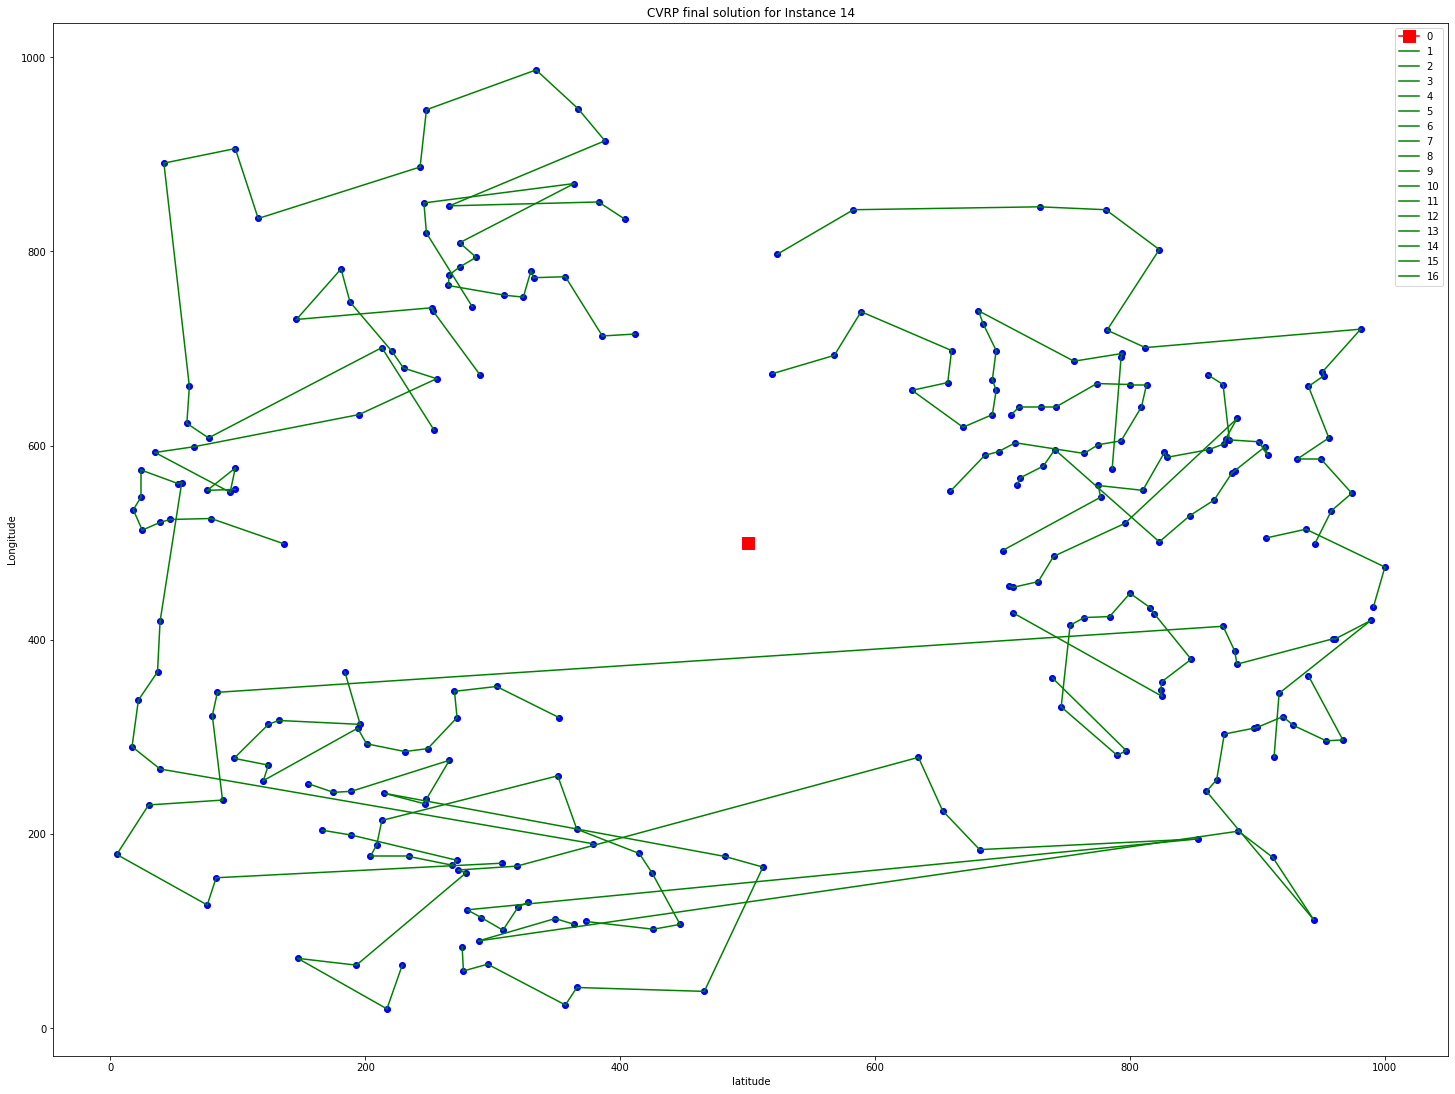

In [28]:
tic = time.time()

data_information = dataset_info()

rows, Files_name = get_files(data_information)

Locations, Demands = get_table(data_information, Files_name)

df = Locations['loc13'].astype(float)

num_of_customer = data_information.loc[13,'Nom_of_node']

customer_list = [i for i in range(1,num_of_customer+1 )]

all_nodes = [i for i in range(num_of_customer+1)]

coords = [(i,j) for i in all_nodes for j in all_nodes if i!=j]

variable = {(i,j):0 for i,j in coords}

distance = {(i,j): round(math.dist((df['x'][i],df['y'][i]), (df['x'][j],df['y'][j]))) for i,j in coords}

f_star = data_information.loc[13, 'UB']

demand = Demands['dem13']['d'].astype(float)           

capacity = data_information.loc[13,'veh_cap']

K_min = data_information.loc[13,'K_min']

parameters = {'num_of_customer':num_of_customer,
              'customer_list': customer_list,
              'all_nodes': all_nodes,
              'coords': coords,
              'distance': distance,
              'demand': demand,
              'capacity': capacity}


Rout = initial_solution(parameters,distance)
X = active_graph(Rout)
check, demand_pass = check_feasibility(X, parameters, Rout)
Ob_fun_Ev = 0
active_arcs = [i for i in coords if X[i]>0]

loss = comput_cost(distance, active_arcs)
Ob_fun_Ev +=1

# # initial sa parametes

GLOBAL_OPTIMAL = float(loss)                    #Global optimom 
bestSoFarLoss = loss
NUMBER_OF_ITERATIONS =2                         #a parameter that need tuning 
initiaTemperature = 50      
temperature=initiaTemperature                    #value of temperature for every interation
coolingRate = 0.999                             #Temperature decrease rate
finalTemperatur=0.001                              #final rate or termination condination
iterationNumber =0                               # iteration counter
badsulotion = 0
notImproveBestSoFar=0                            #comute the count of iteration without improving 
bestSoFarRout={}                                 #Best rout
currentRout = {}                                 #to save current path
BestSoFarRout = {}
currentRout = Rout.copy()
bestSoFarRout = Rout.copy()
Rout1 = Rout.copy()

i=0
Loss=[]
Temperature=[]
while temperature>finalTemperatur:
    print('loss is:', loss,'<=====> bestsofar is: ', bestSoFarLoss, ' temprature is:', temperature)
    Loss.append(bestSoFarLoss)
    Temperature.append(temperature)
    
    if bestSoFarLoss<GLOBAL_OPTIMAL:
        GLOBAL_OPTIMAL = bestSoFarLoss
        BestSoFarRout = bestSoFarRout
    for counter in range(NUMBER_OF_ITERATIONS):
        Feasibility = False
        Rout = neighborhood(parameters,bestSoFarRout,distance,iterationNumber)
        
        X = active_graph(Rout)
        Feasibility, rout_demand = check_feasibility(X, parameters, Rout)
#         if Feasibility == True:
            
        currentRout = Rout.copy()
        X = active_graph(currentRout)
        active_arcs = [i for i in coords if X[i]>0]
        loss = comput_cost(distance, active_arcs)
        Ob_fun_Ev +=1
        if loss <= bestSoFarLoss:
                
            bestSoFarLoss = loss
            bestSoFarRout = currentRout.copy()
        else:
                
            delta_loss = (bestSoFarLoss - loss)
                
            r = np.random.uniform()
            if r < np.exp(delta_loss/temperature):
                bestSoFarLoss = loss
                bestSoFarRout = currentRout.copy()
                badsulotion +=1
                
            else: notImproveBestSoFar+=1
    temperature = coolingRate * temperature
    iterationNumber +=1
    i+=1
toc = time.time()
Running_time = (toc - tic)/60
gap = round((GLOBAL_OPTIMAL-f_star) /f_star*100, 1)
print(iterationNumber)
print(BestSoFarRout)
print(Running_time)
print(gap,'%')
with open ('problem14-1.txt','w') as f:
    f.write('Number of Iteration: '+str(iterationNumber)+'\n')
    f.write('Best so far loss: ' + str(bestSoFarLoss)+'\n' )
    f.writelines('execute time: '+str(Running_time)+'\n')
    f.write('The number of bad solution that was accepted in the algorithm : '+str(badsulotion)+'\n')
    f.write('The total number of times that the objective function is evaluated: '+str(Ob_fun_Ev)+'\n')
    for row in bestSoFarRout.keys():
        f.writelines('Route'+str(row)+': '+str(bestSoFarRout[row])+'\n')
    f.write('Gap: '+str(gap)+'%')

x_d, y_d, x_c, y_c = coordinates(df, data_information)
arcs = [(i,j) for i in customer_list for j in customer_list if i!=j]
visible_node = [a for a in arcs if X[a]>0]
plt.figure(figsize=(25,19))
groups = [i for i in bestSoFarRout.keys()]
ax = plt.subplot(111)
plt.plot(x_d, y_d, 'r',marker ='s', Markersize=12 )
plt.scatter(x_c, y_c,c='b', marker='o')
k=0
for i,j in visible_node:
    plt.plot([df['x'][i], df['x'][j]],[df['y'][i], df['y'][j]],'g')
plt.title("CVRP final solution for Instance 14")
plt.ylabel("Longitude")
plt.xlabel("latitude")
plt.legend(groups)
plt.savefig('problem 14')

In [80]:
data_information

,file_name,Nom_of_node,K_min,veh_cap,UB,Opt.
0,X-n101-k25.txt,100,25,206,27591,yes
1,X-n106-k14.txt,105,14,600,26362,yes
2,X-n110-k13.txt,109,13,66,14971,yes
3,X-n120-k6.txt,119,6,21,13332,yes
4,X-n125-k30.txt,124,30,188,55539,yes
5,X-n134-k13.txt,133,13,643,10916,yes
6,X-n139-k10.txt,138,10,106,13590,yes
7,X-n148-k46.txt,147,46,18,43448,yes
8,X-n219-k73.txt,218,73,3,117595,yes
9,X-n233-k16.txt,232,16,631,19230,yes


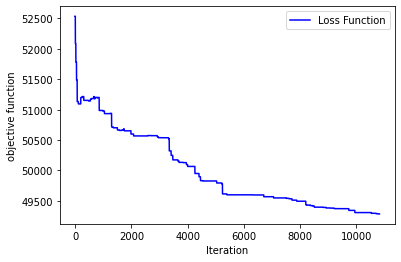

In [27]:
plt.plot(Loss, 'b', label='Loss Function')
plt.legend()
plt.ylabel('objective function')
plt.xlabel('Iteration')
plt.savefig('loss function 13')